In [2]:
from helpers import mds
from collections import defaultdict
from PIL import Image
from scipy.stats import pearsonr
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import numpy as np
from accuracy_metrics import accuracy
import torchvision.datasets
from helpers import fetch_constant
dataset_path = fetch_constant("caltech_dataset_path")
dataset = torchvision.datasets.Caltech101(root = dataset_path,download = False )
%matplotlib widget
from helpers import fetch_constant
import pymongo
cl = pymongo.MongoClient(fetch_constant('mongo_db_cs'))
db = cl["caltech101db"]
collection = db[fetch_constant('phase2Trainingset_collection_name')]
featurespace="resnet50_avgpool"
odd_collection = db[fetch_constant('odd_images_collection_name')]
odd_dataset = list(collection.find({},{'_id':0,'label':1,f"{featurespace}_feature_descriptor":1}))

In [4]:
# Function to calculate pearson distance
def pearson_correlation_distance(a,b):    
    temp = pearsonr(a,b).statistic
    return 1-temp
# Fuction to calculate euclidian distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))
#Creating a matrix which contains the distances from each point to every other point in the even dataset
def create_distance_matrix(data,distance_type):
    d_matrix = []
    distance_mat = np.zeros(shape=(len(data),len(data)))
    for idx1,p1 in enumerate(data):
        distance = []
        for idx2,p2 in enumerate(data):
            if idx2<idx1:
                distance.append(distance_mat[idx2][idx1])
            else:
                if distance_type == "euclidian":
                    distance_mat[idx1][idx2]=euclidean_distance(p1,p2)
                elif distance_type == "pearson":
                    distance_mat[idx1][idx2]=pearson_correlation_distance(p1,p2)
                distance.append(distance_mat[idx1][idx2])
        d_matrix.append(distance)
    return d_matrix
# Function to find all the neighbors near passed point id within the distance of epsilon
def region_query_v2(d_matrix,point_id,eps):
    seeds = []
    for i,dist in enumerate(d_matrix[point_id]):
        if dist<eps:
            seeds.append(i)
    return seeds
# Function to get a list of distances of kth nearest point of each point
def calculate_kn_distance_v2(d_matrix,k):
    kn_dist = []
    for distances in d_matrix:
        temp = sorted(distances)
        kn_dist.append(temp[k])
    return kn_dist
# Function to look into neigbors of point and add them to cluster and expand them in case they are core points
def expand_cluster_v2(d_matrix, classifications, point_id, cluster_id, eps, min_points):
    seeds = region_query_v2(d_matrix, point_id, eps)
    if len(seeds) < min_points:
        classifications[point_id] = -1
        return False
    else:
        classifications[point_id] = cluster_id
        for seed_id in seeds:
            classifications[seed_id] = cluster_id

        while len(seeds) > 0:
            current_point = seeds[0]
            results = region_query_v2(d_matrix, current_point, eps)
            if len(results) >= min_points:
                for i in range(0, len(results)):
                    result_point = results[i]
                    if classifications[result_point] == 0 or classifications[result_point] == -1:
                        if classifications[result_point] == 0:
                            seeds.append(result_point)
                        classifications[result_point] = cluster_id
            seeds = seeds[1:]
        return True

def dbscan_v2(d_matrix, eps, min_points):
    cluster_id = 1
    n_points = d_matrix.shape[0]
    classifications = [0]*n_points
    for point_id in range(0, n_points):
        point = d_matrix[point_id,:]
        if classifications[point_id] == 0:
            if expand_cluster_v2(d_matrix, classifications, point_id, cluster_id, eps, min_points):
                cluster_id = cluster_id + 1
    return classifications
# Function to generate combinations of minpts and epsilons to try out and get required c number of clusters
def create_combinations2(min,mean,minPts,divisions):
    a_arr=[]
    decrement = (mean-min)/divisions
    j= decrement
    while mean-j>min:
        a_arr.append(mean-j)
        j+=decrement
    result = []
    for i in a_arr:
        result.append((i,minPts))
    return result   
# Function to count the number of points within each cluster
def cluster_count(clusters):
    temp = dict()
    for k in clusters:
        if k in temp.keys():
            temp[k]+=1
        else:
            temp[k] = 1
    return temp
# Function to find all the core points of the clustering for given label
core_pts = []
def get_core_points(label,d_matrix,label_dataset,eps,minPts):
    for point_id in range(len(d_matrix)):
        seeds = region_query_v2(d_matrix, point_id, eps)
        if len(seeds) >=minPts:
            core_pts.append((label,label_dataset[point_id]))
# Function to extract the distances between points belonging to the same label from overall distance matrix
def get_label_distance_matrix(d_matrix,lable_image_ids):
    label_distance_matrix = np.zeros(shape=(len(lable_image_ids),len(lable_image_ids)))
    for idx1,ele1 in enumerate(lable_image_ids):
        for idx2,ele2 in enumerate(lable_image_ids):
            label_distance_matrix[idx1][idx2] = d_matrix[ele1//2][ele2//2]
    return label_distance_matrix

In [5]:
# Creating dictionarys that has keys as label number and values as the feature descriptors 
# of images belonging to that labels and their corresponding image ids
label_dataset = defaultdict(list)
label_image_ids = defaultdict(list)
even_dataset =list(collection.find({},{'_id':0,"image_id":1, 'label': 1,f"{featurespace}_feature_descriptor":1}))
even_images = []
for i in range(len(even_dataset)):
    even_images.append(np.array(even_dataset[i][f"{featurespace}_feature_descriptor"]).flatten())
    label_dataset[even_dataset[i]['label']].append(np.array(even_dataset[i][f"{featurespace}_feature_descriptor"]).flatten())
    label_image_ids[even_dataset[i]['label']].append(even_dataset[i]['image_id'])
d_matrix = create_distance_matrix(even_images,"euclidian")

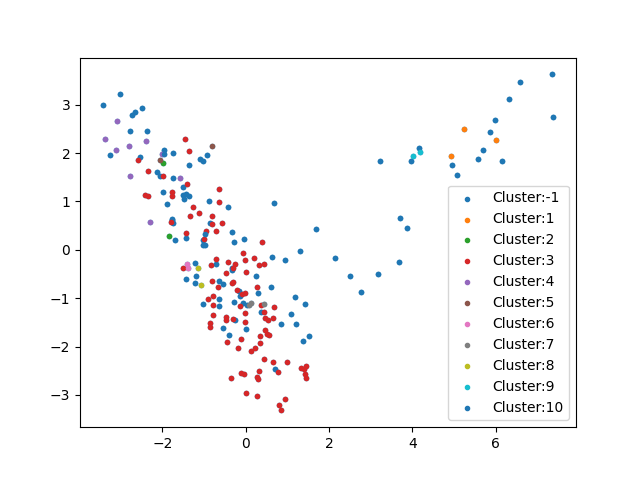

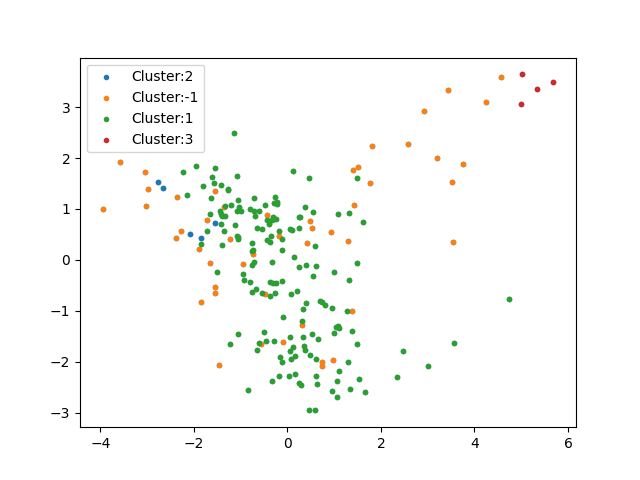

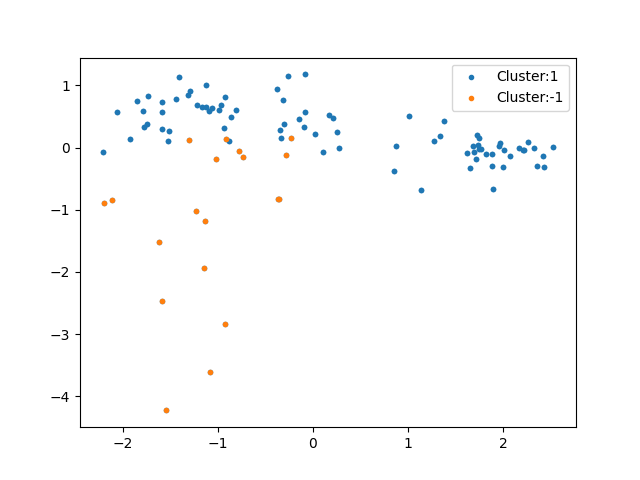

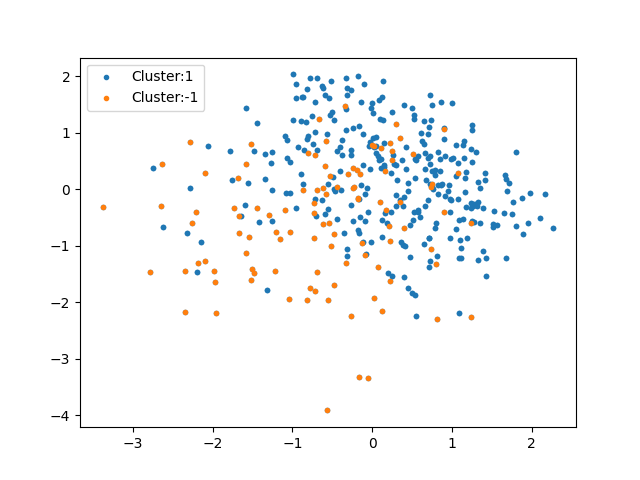

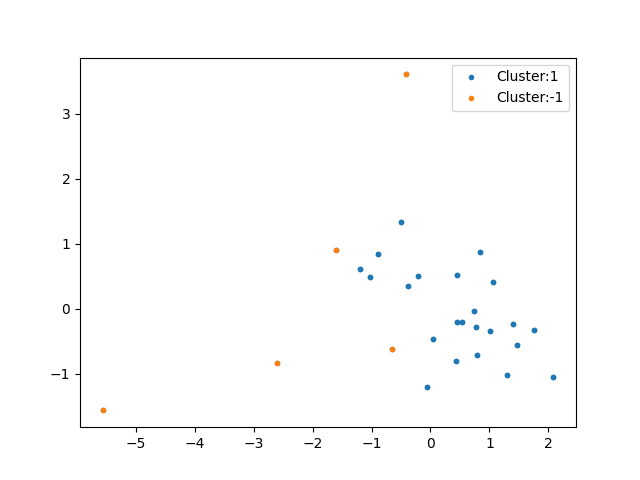

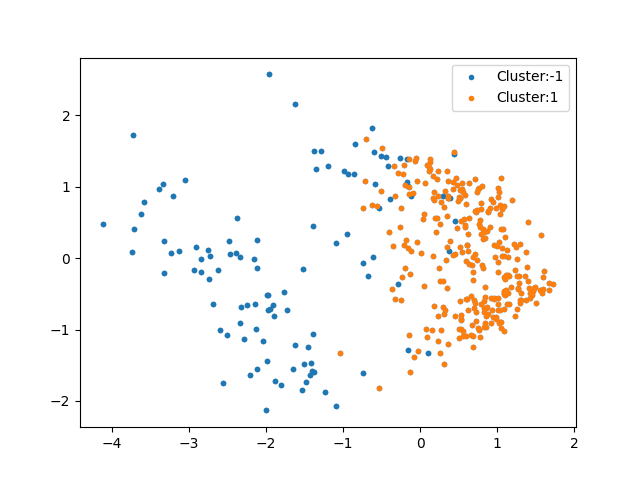

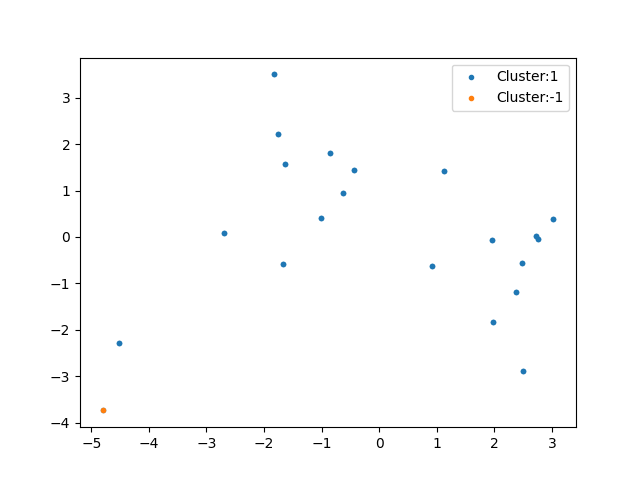

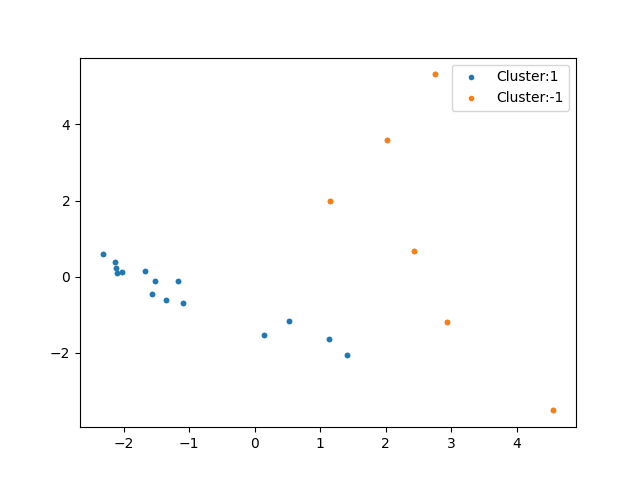

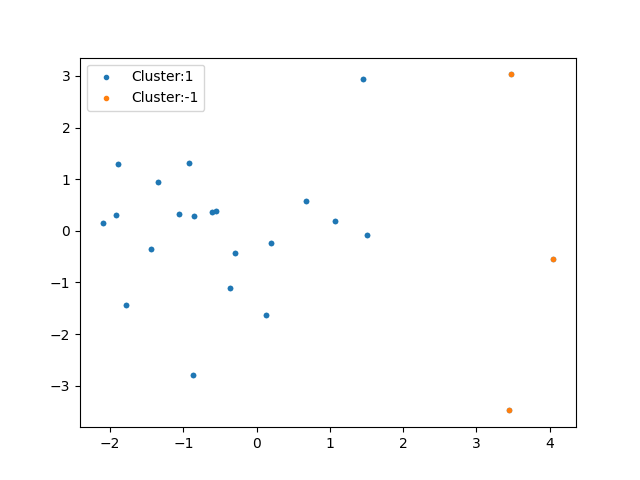

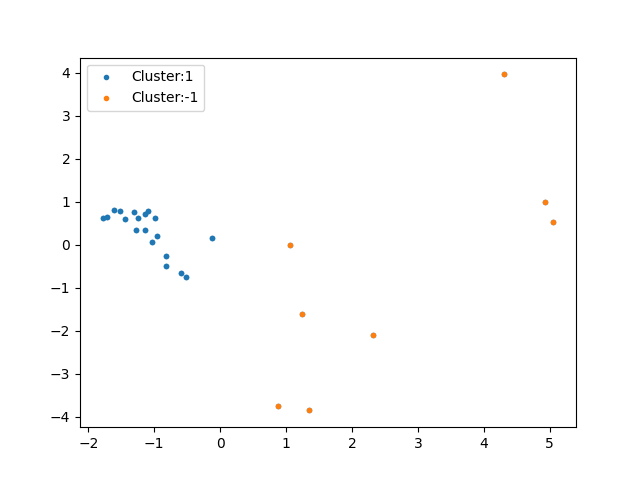

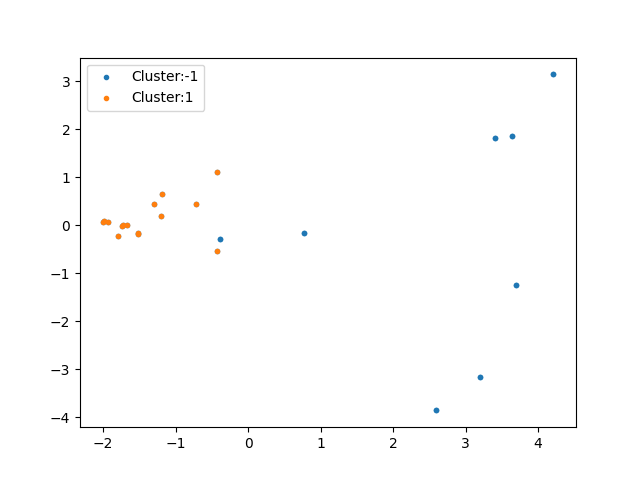

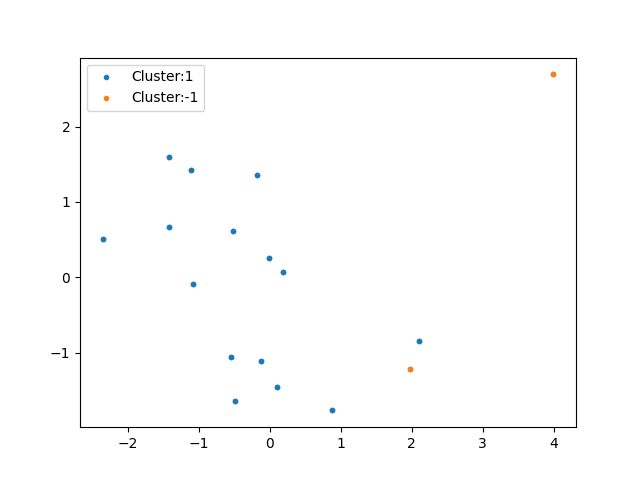

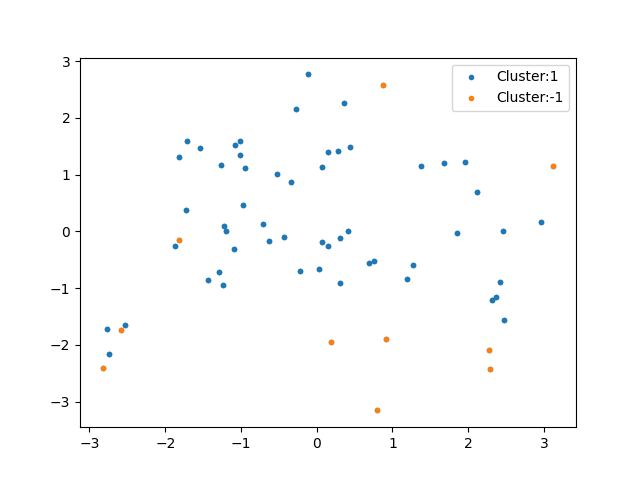

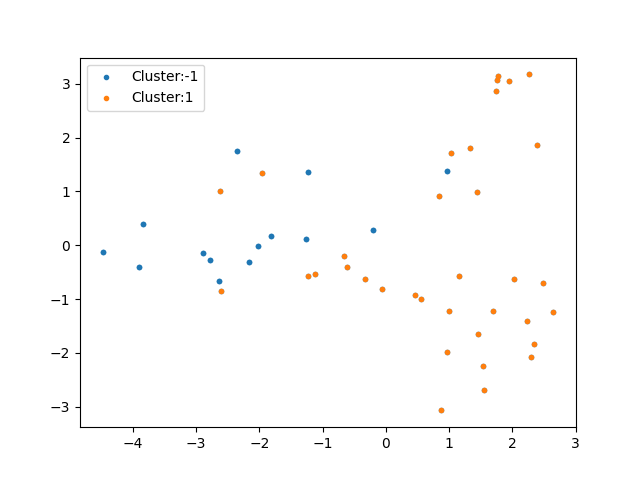

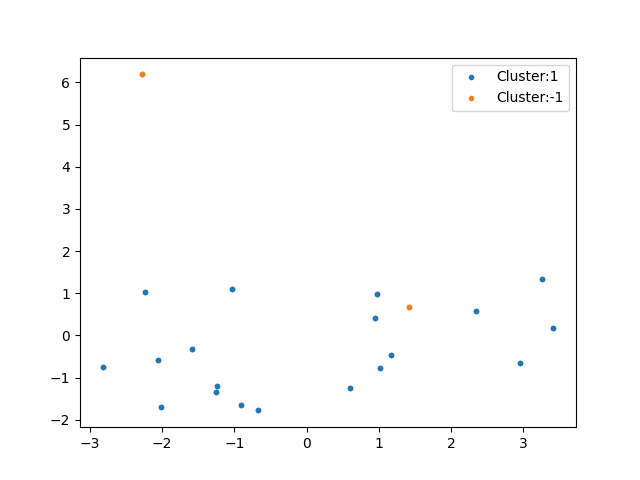

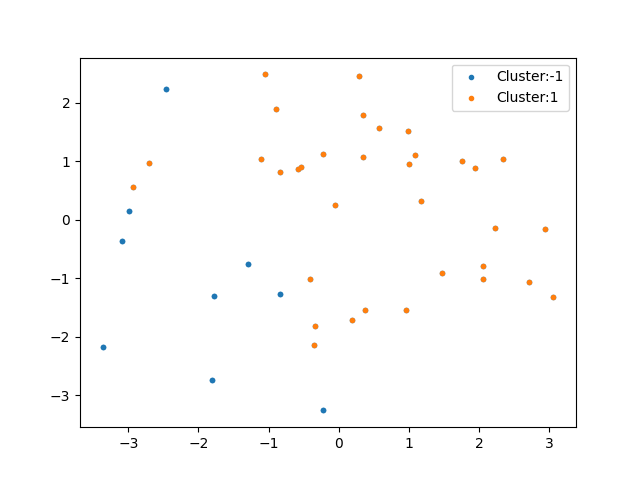

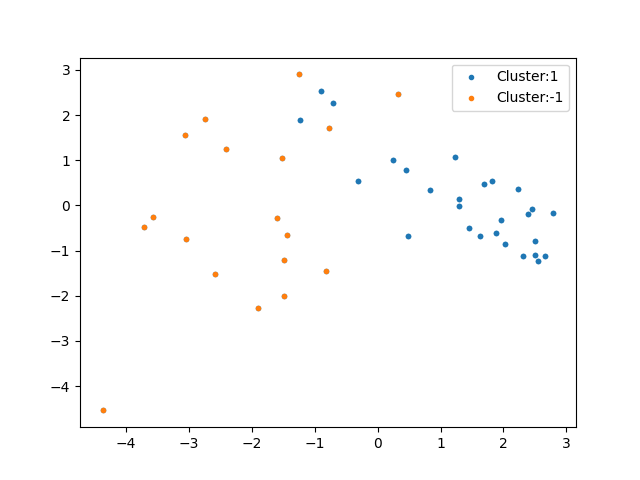

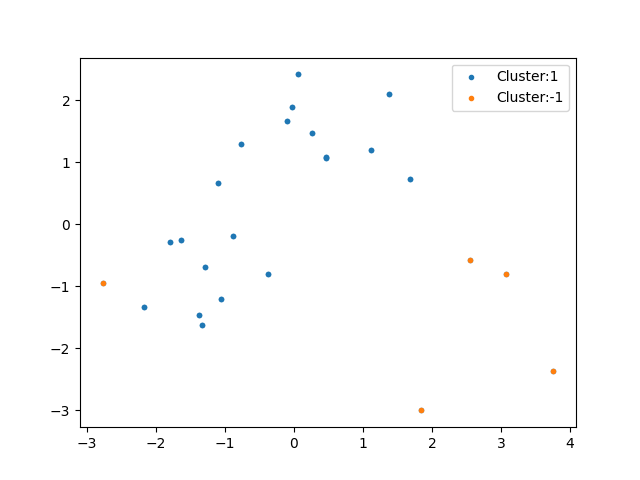

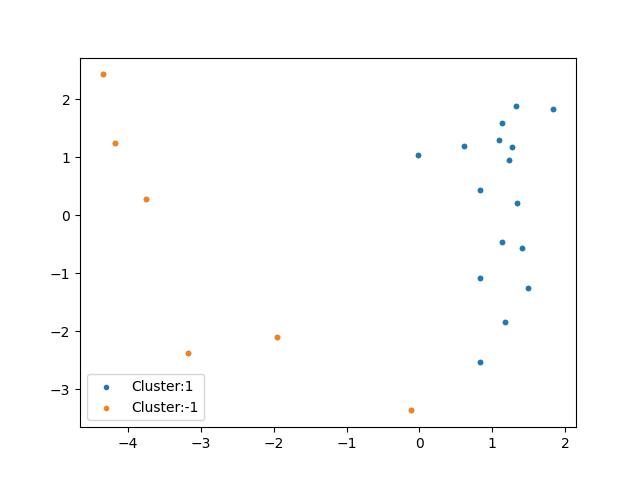

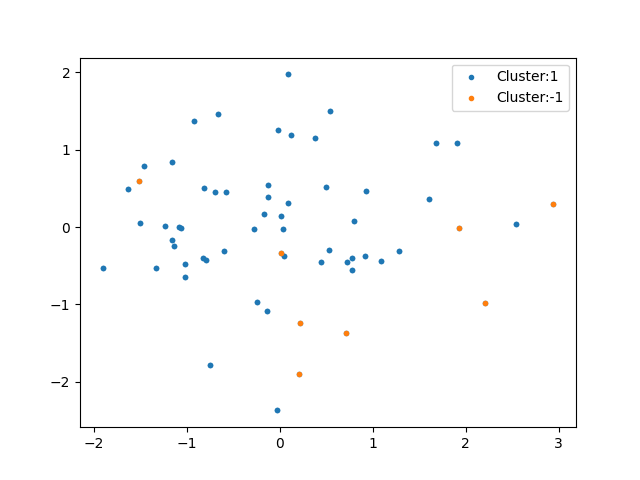

C:\Users\rahul\AppData\Local\Temp\ipykernel_46924\2663112386.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


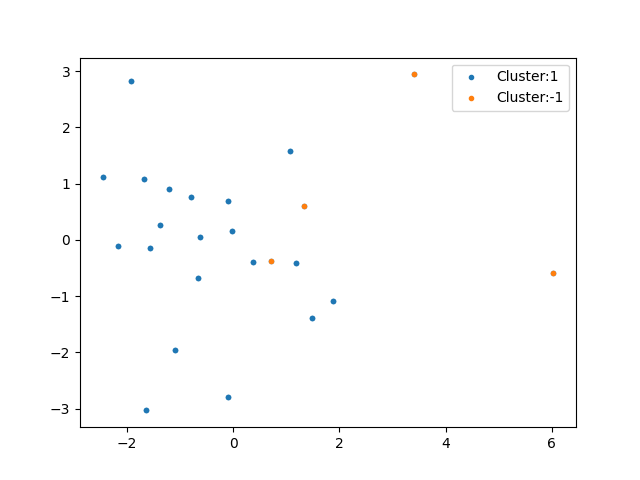

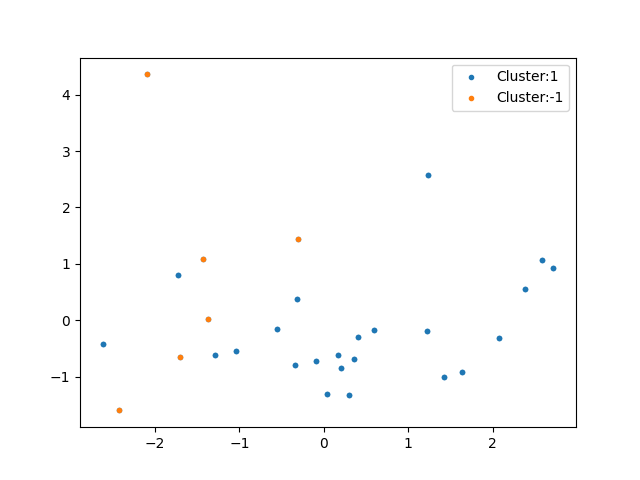

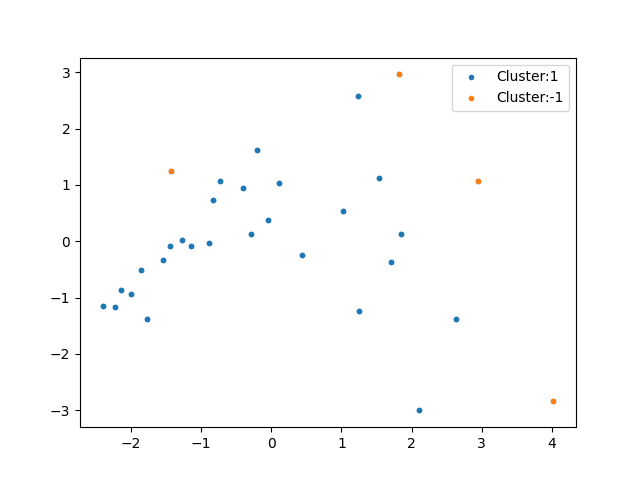

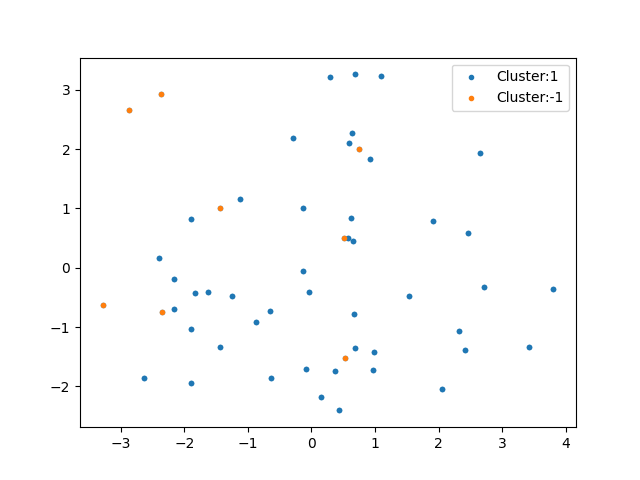

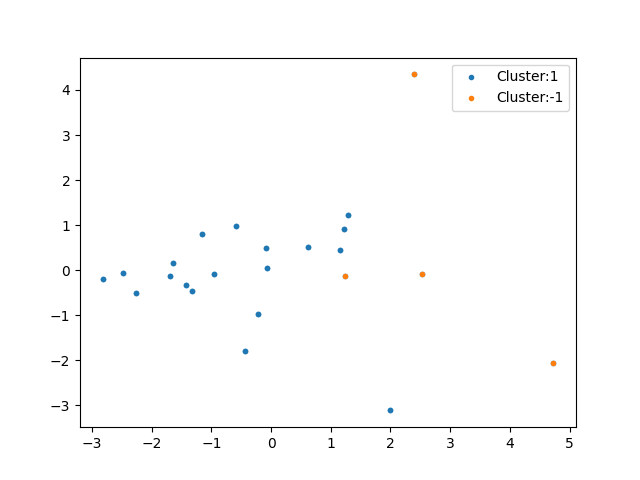

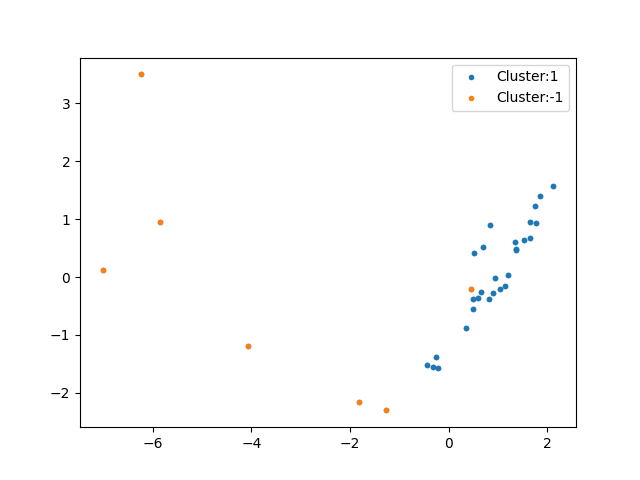

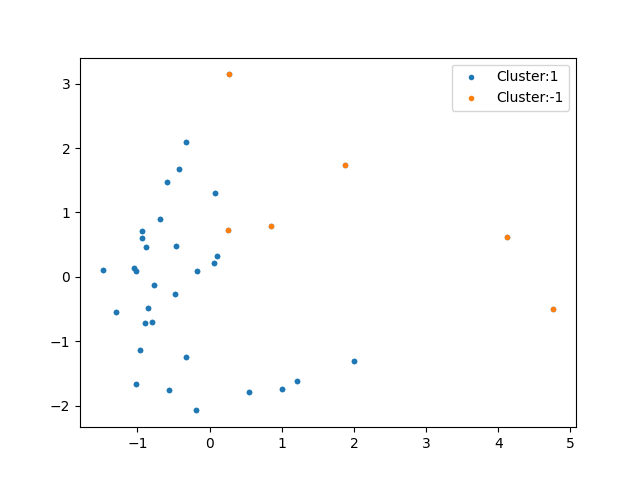

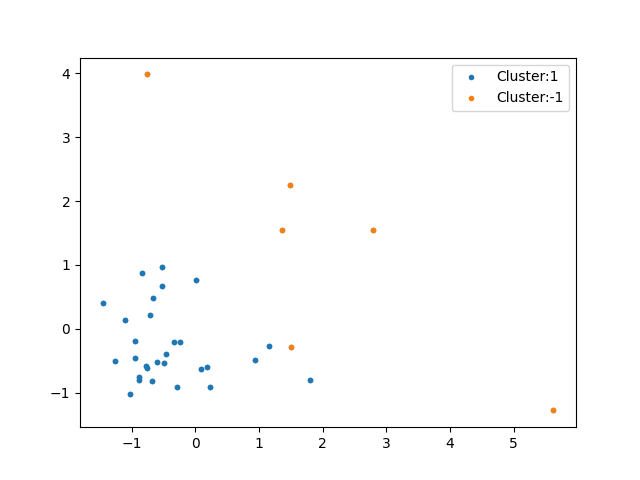

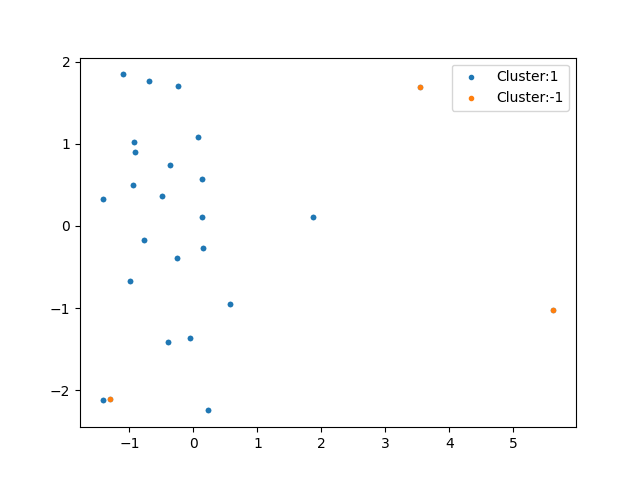

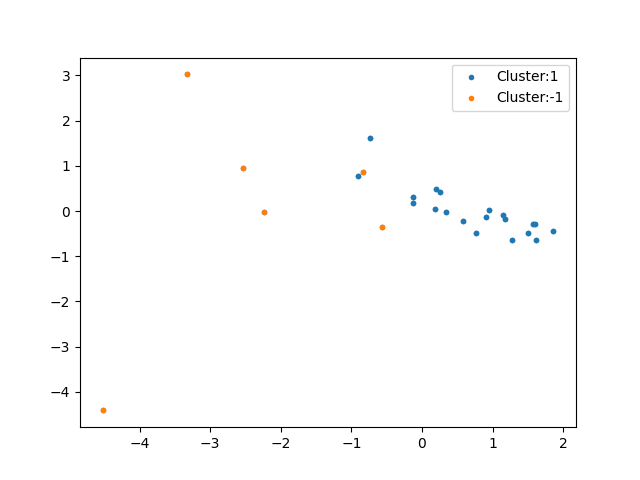

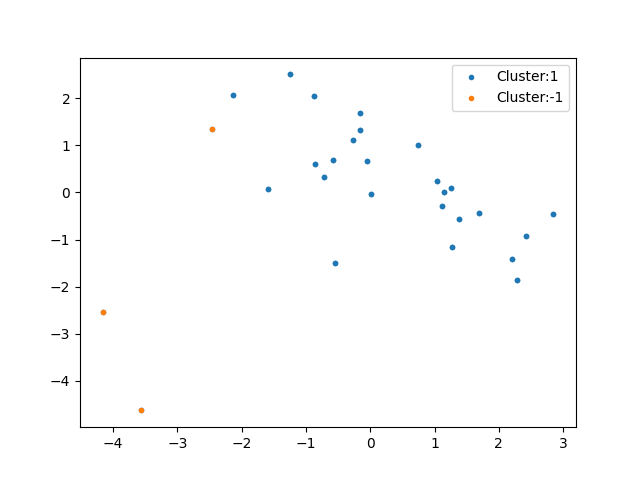

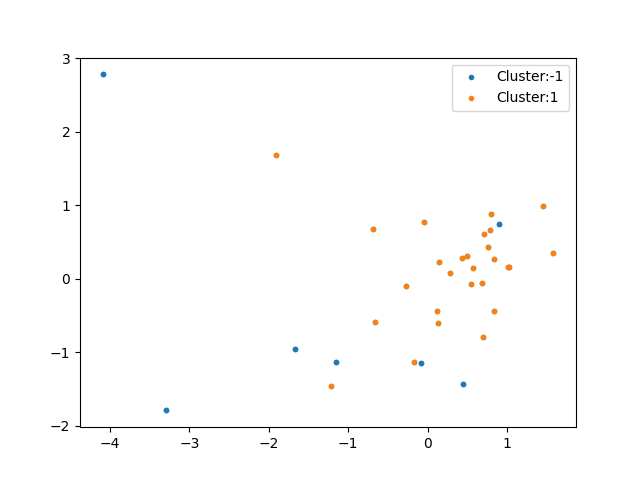

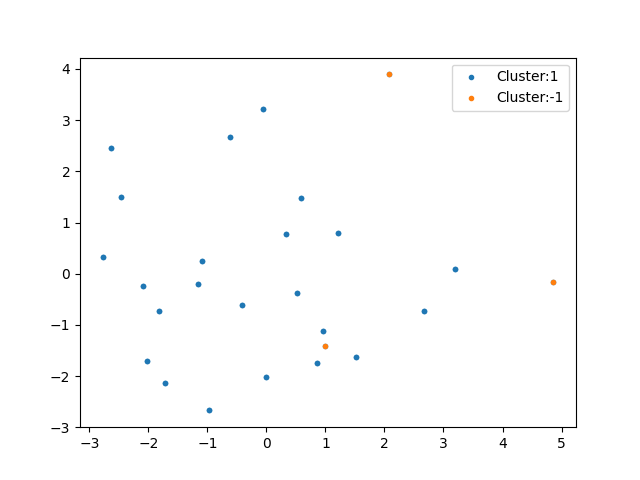

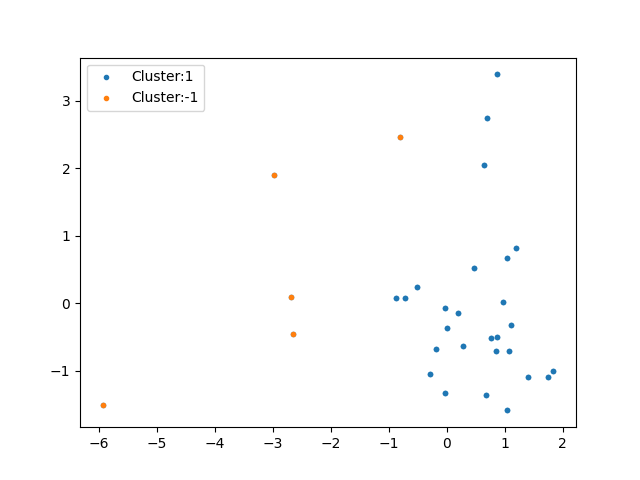

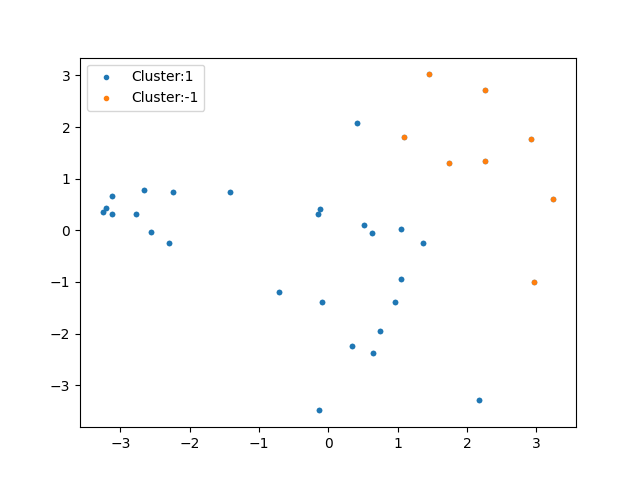

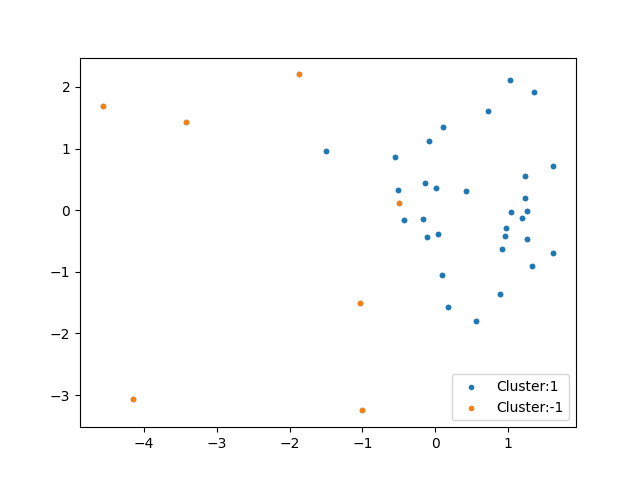

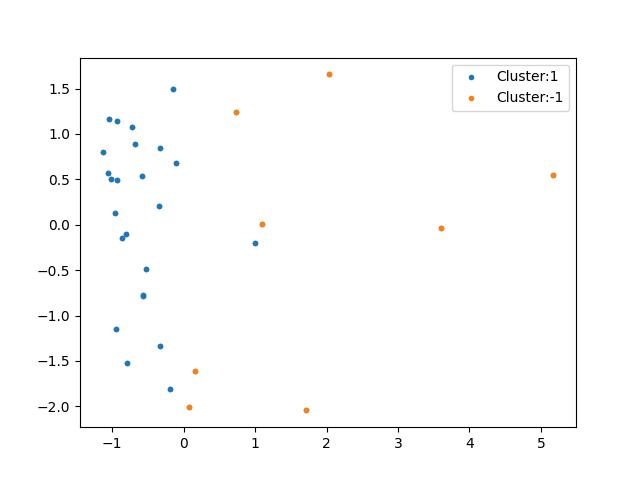

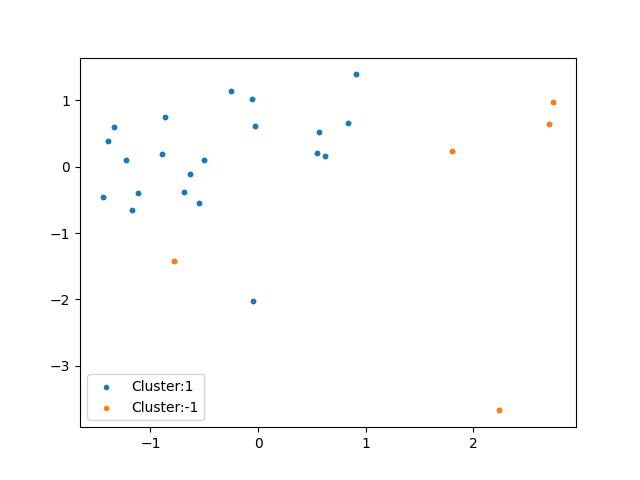

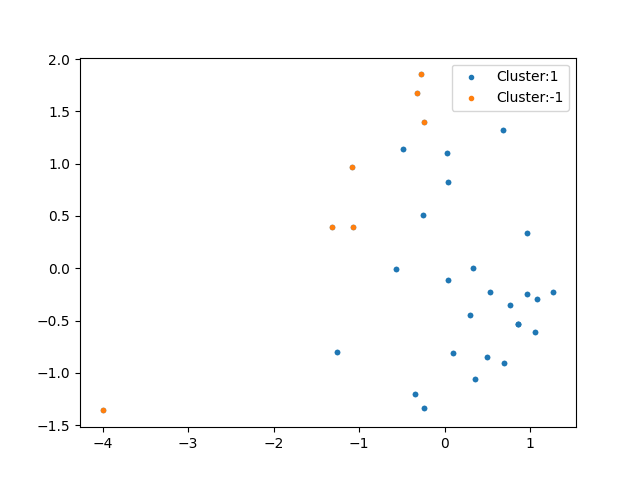

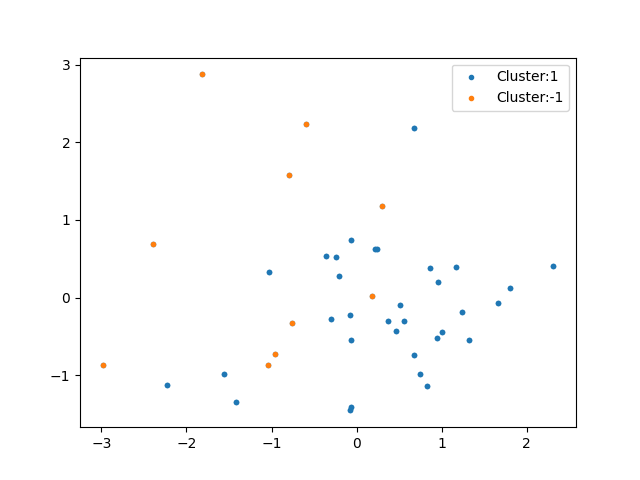

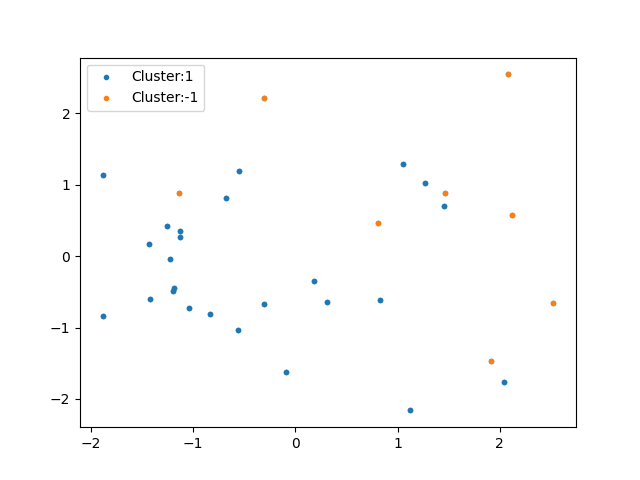

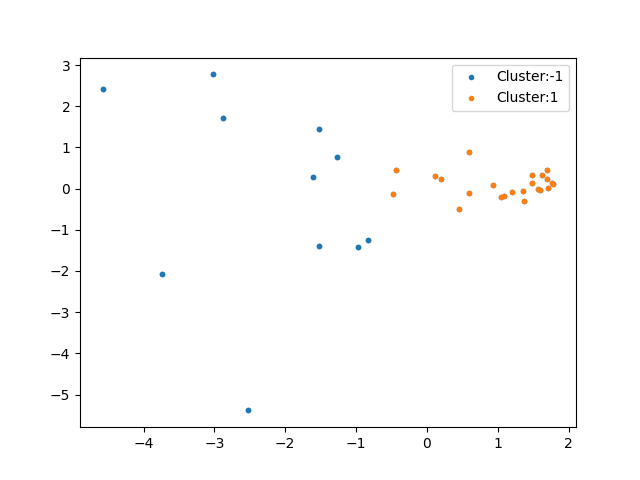

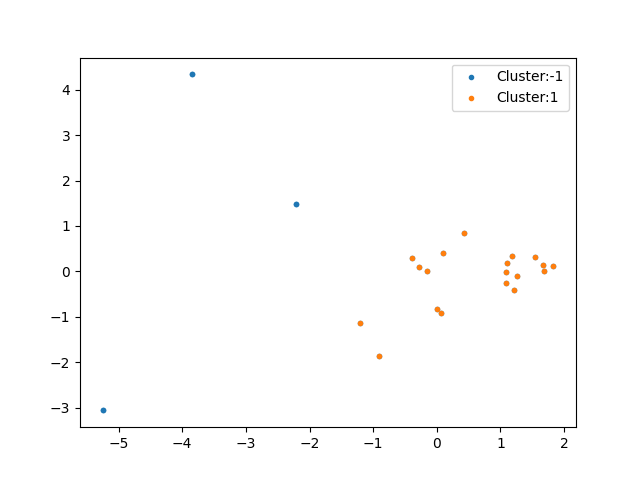

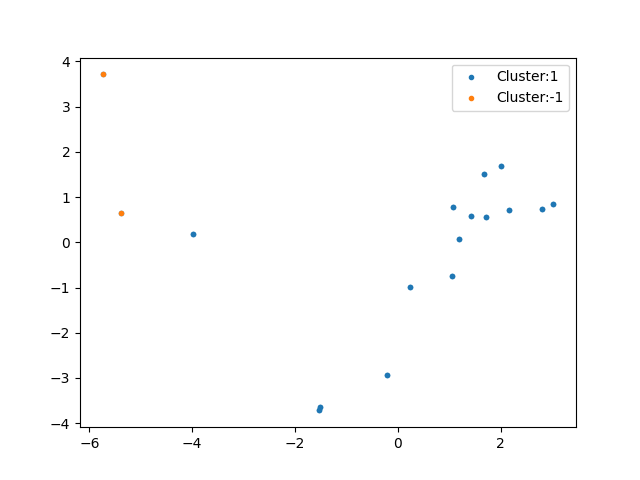

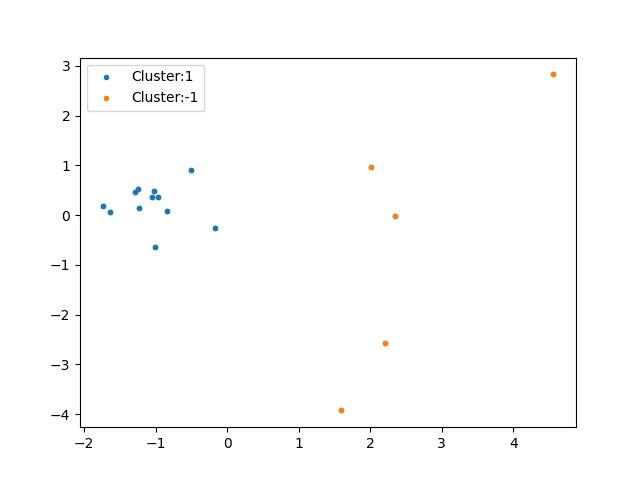

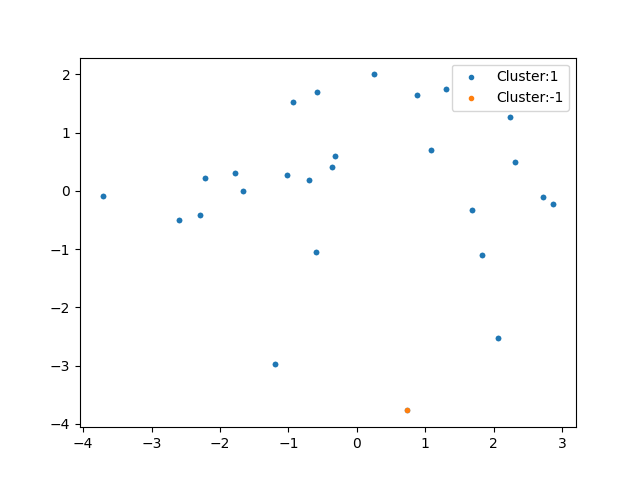

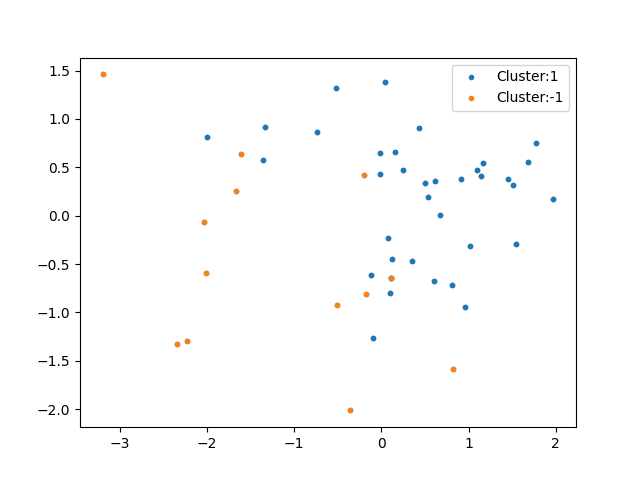

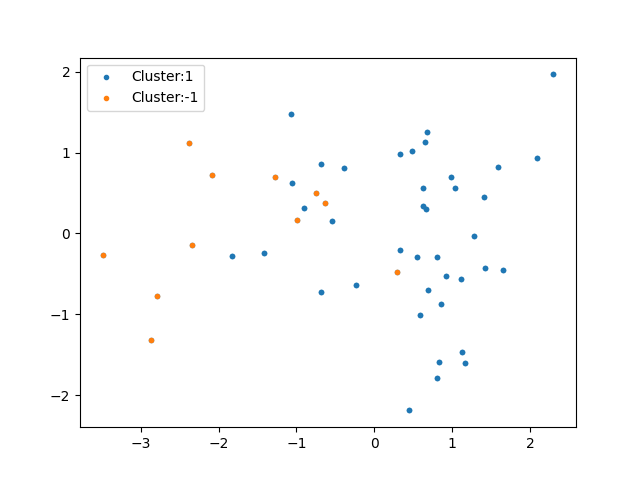

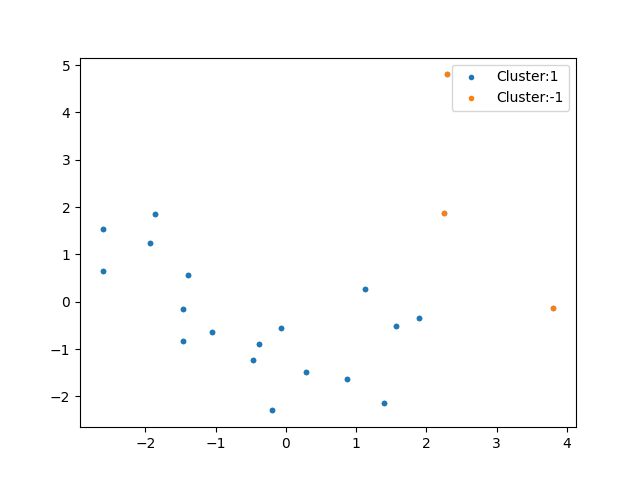

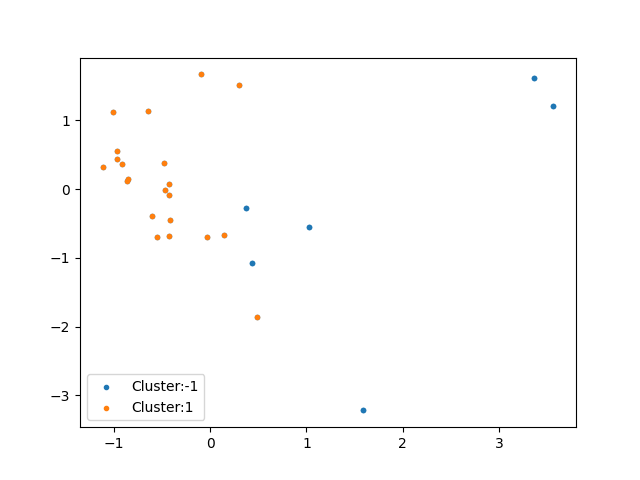

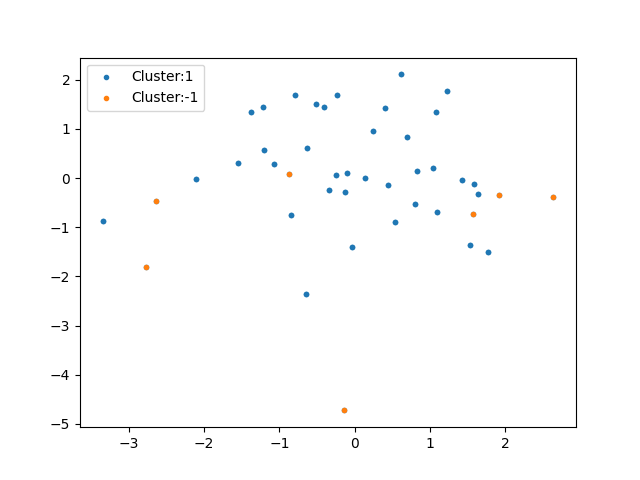

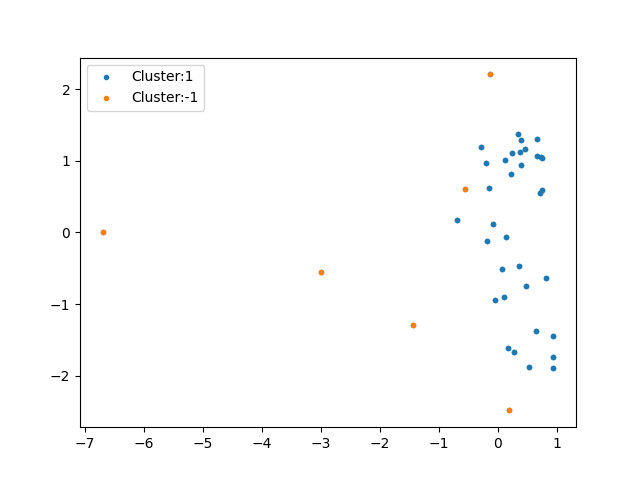

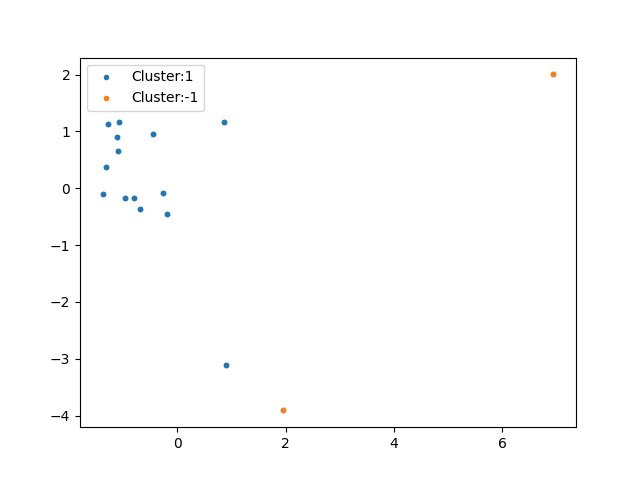

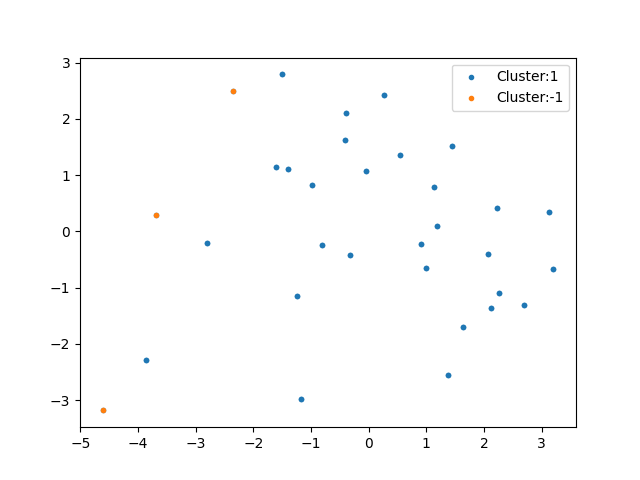

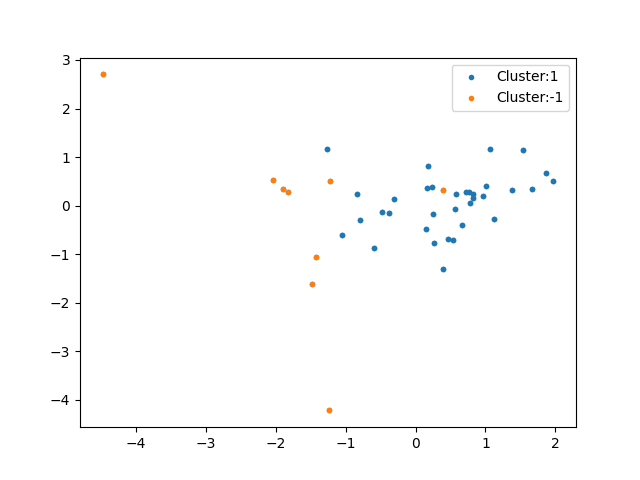

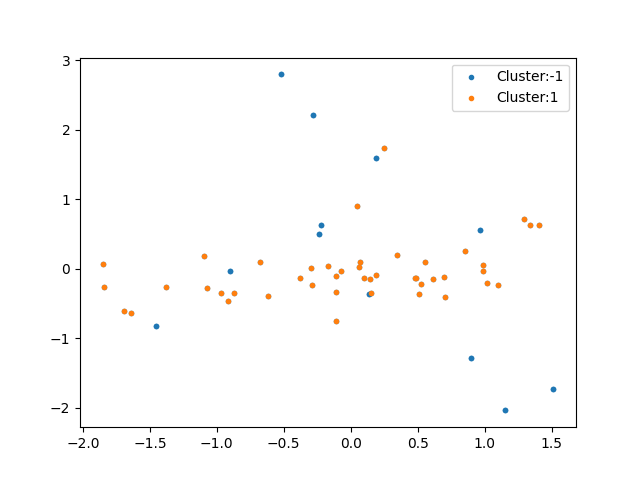

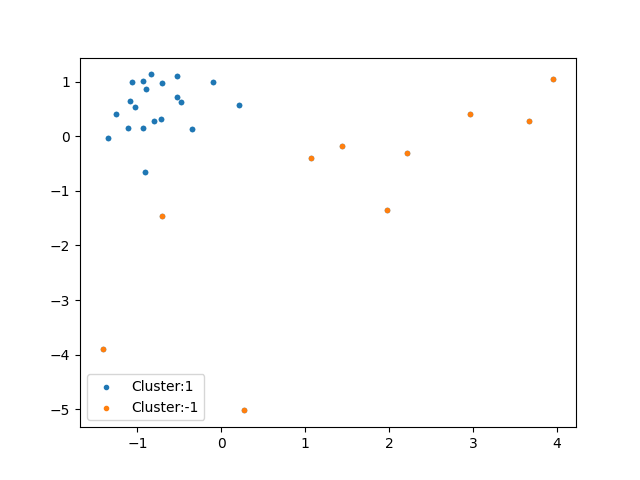

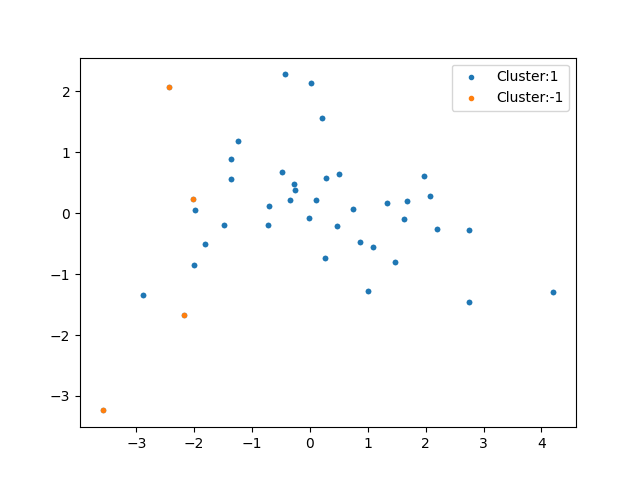

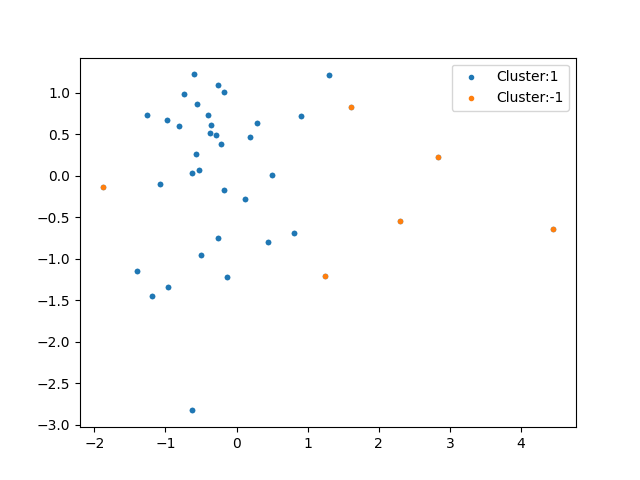

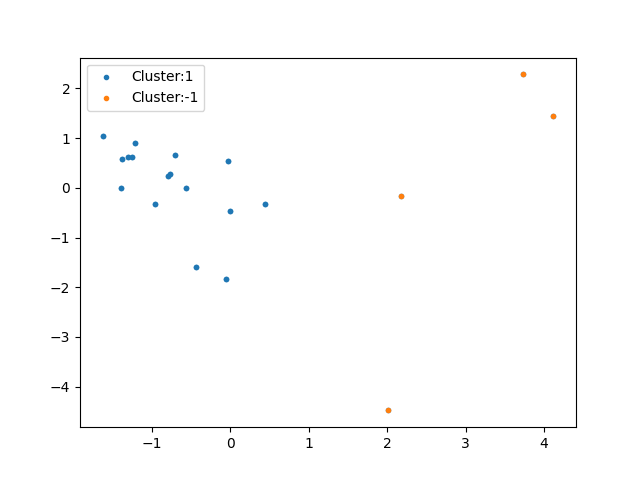

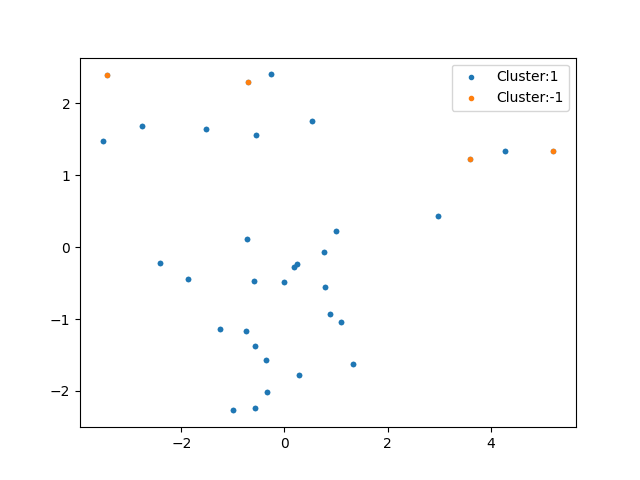

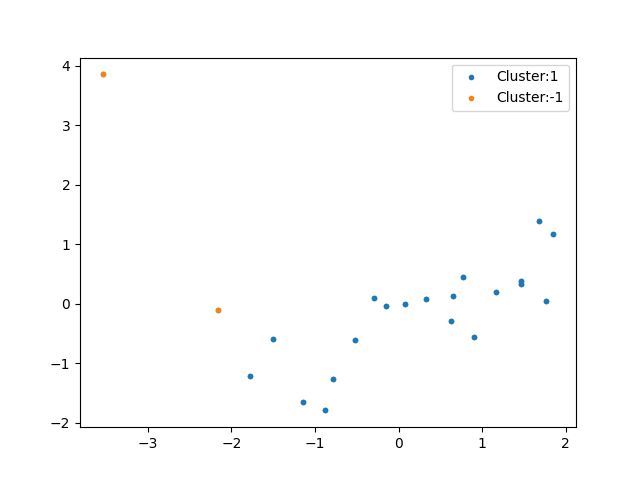

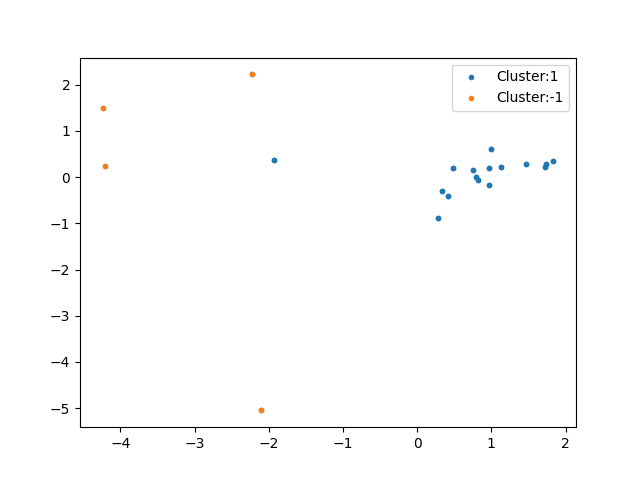

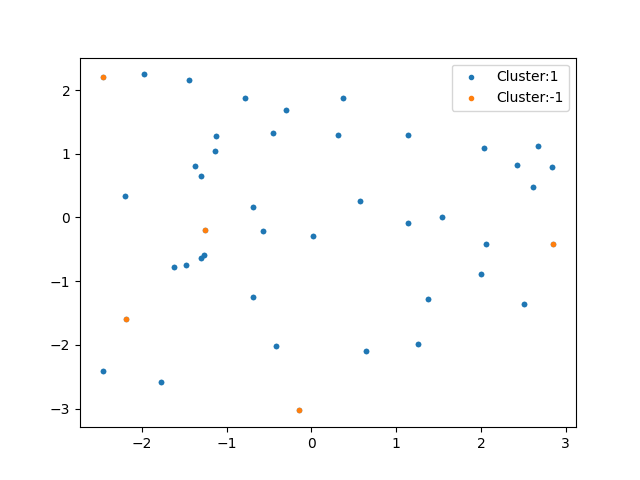

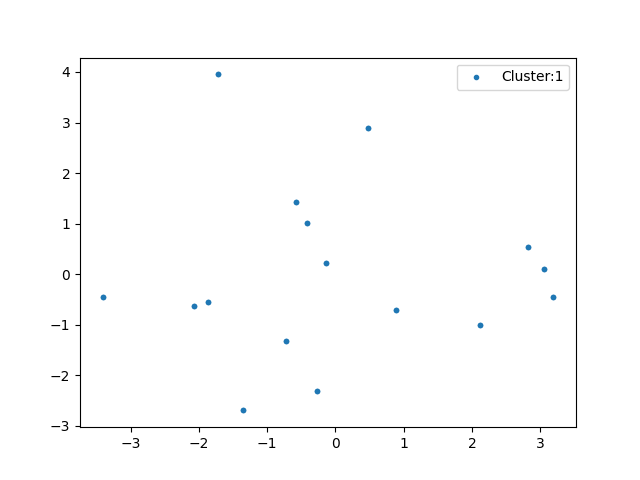

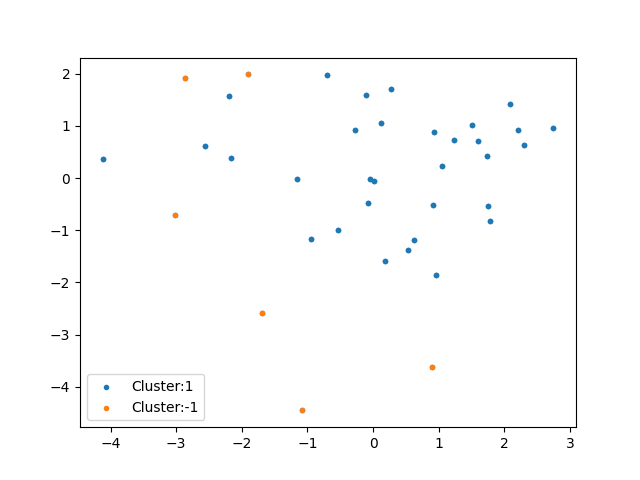

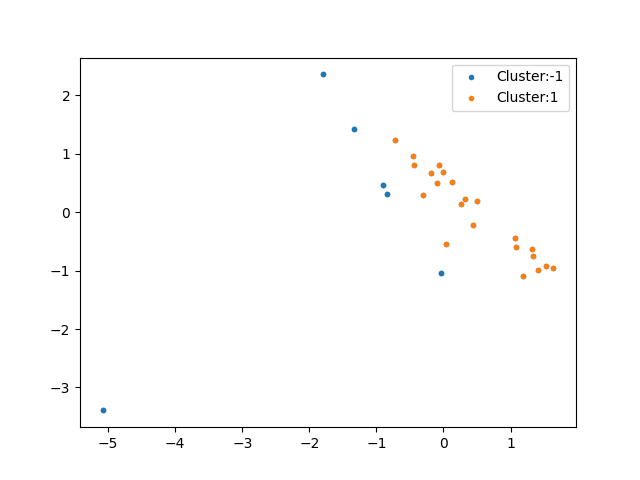

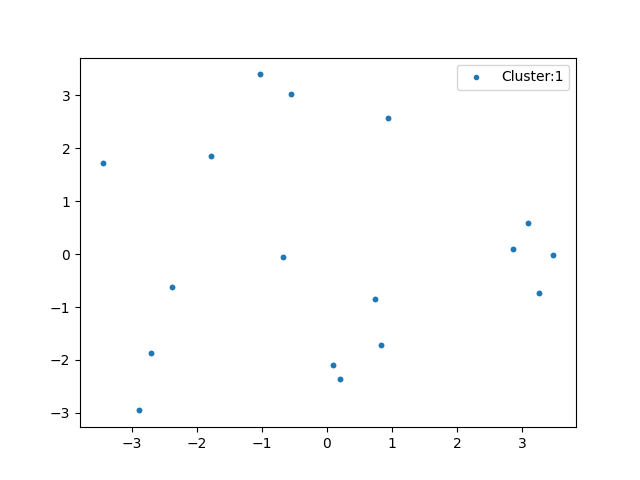

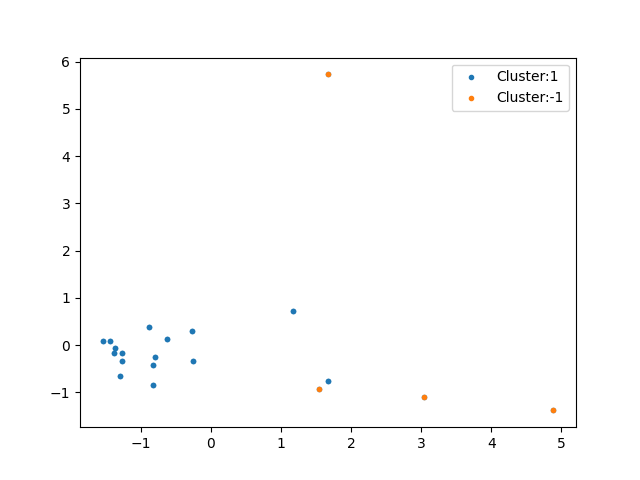

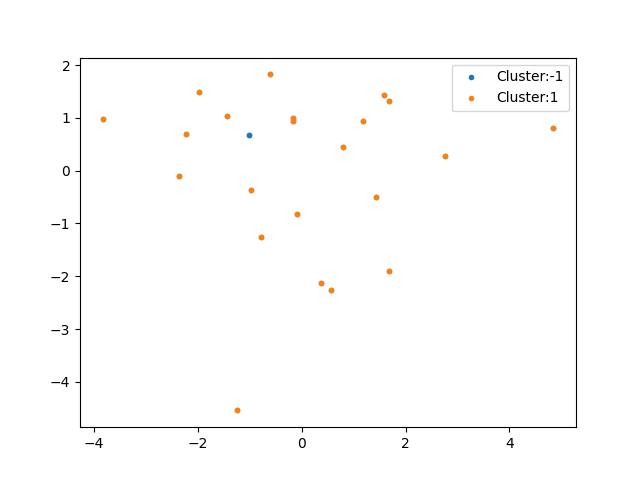

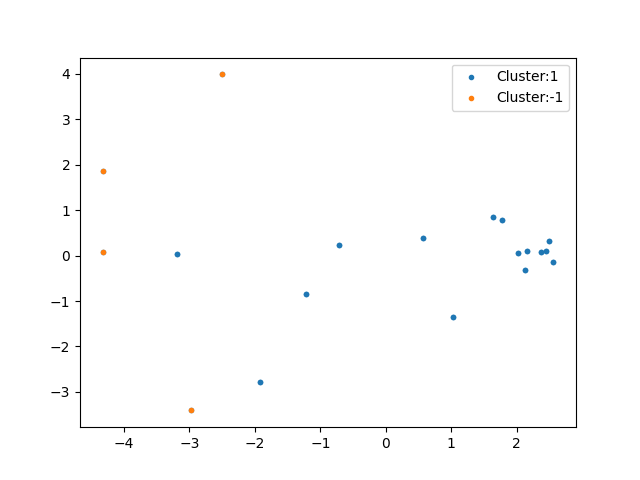

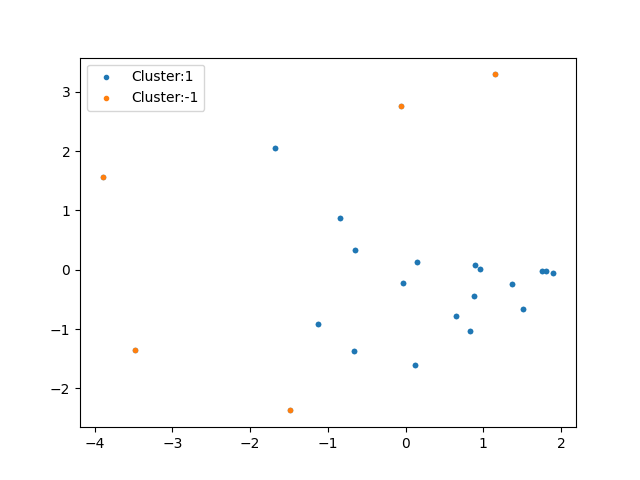

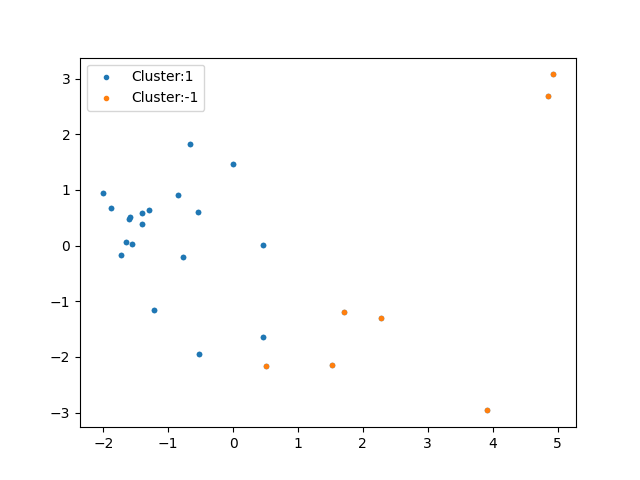

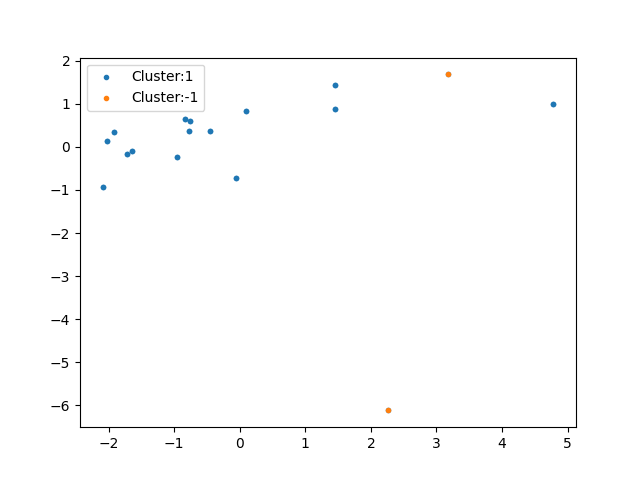

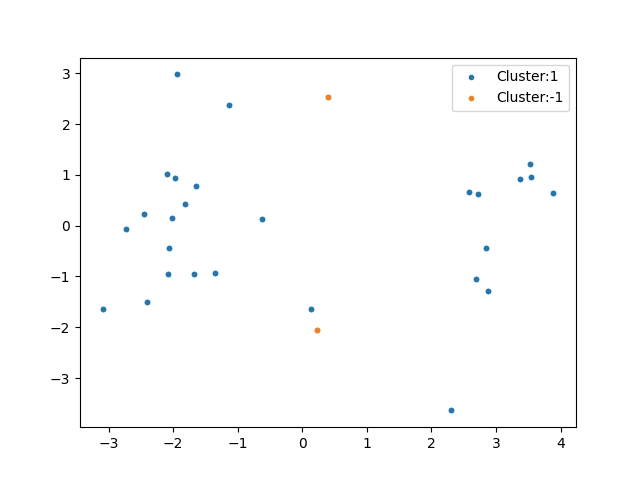

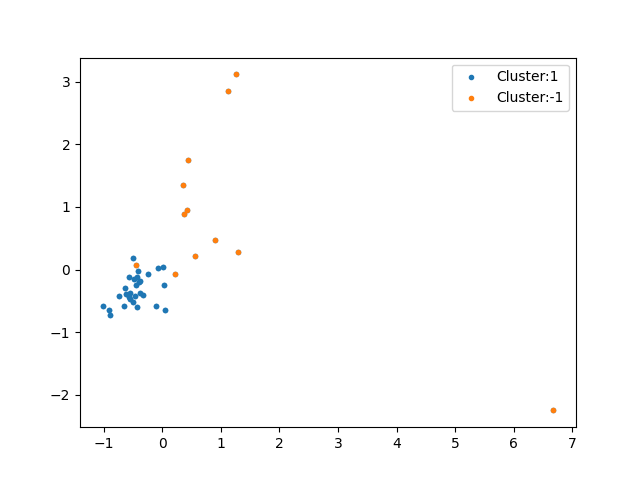

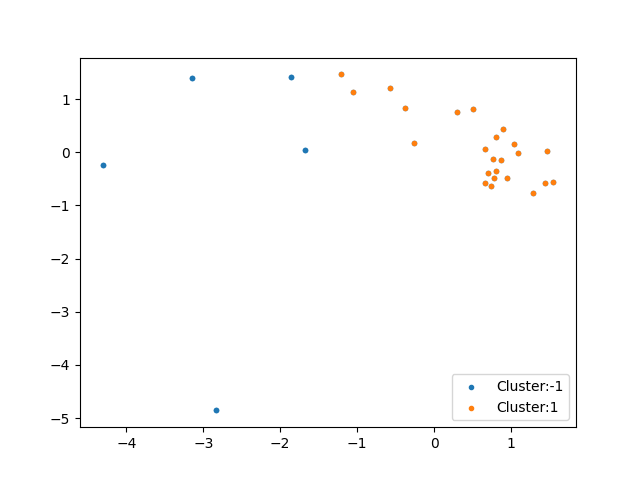

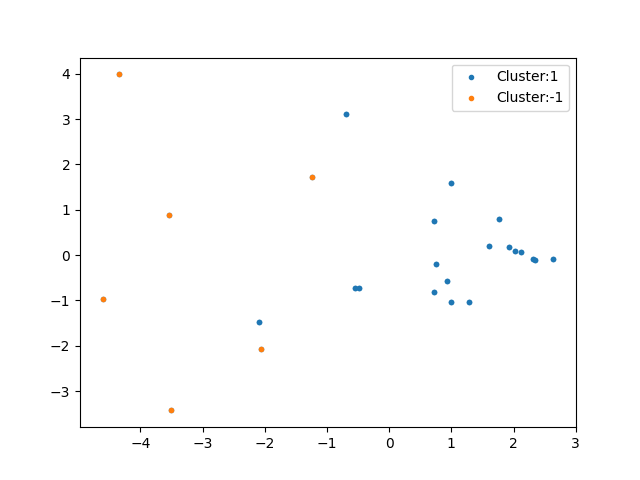

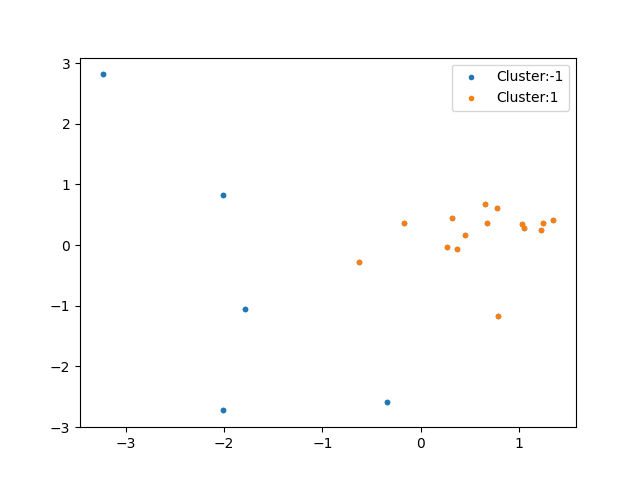

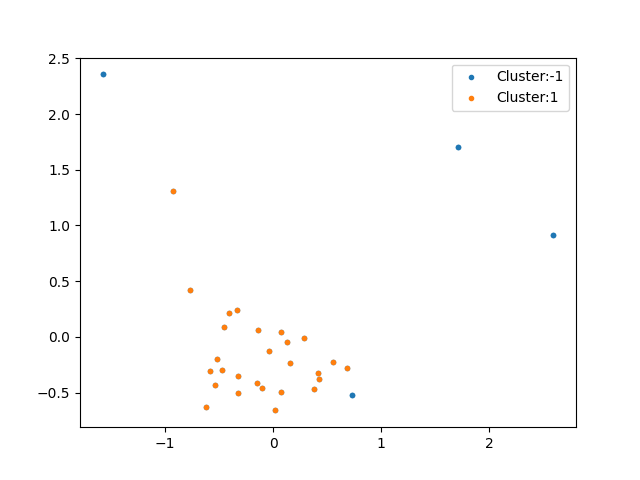

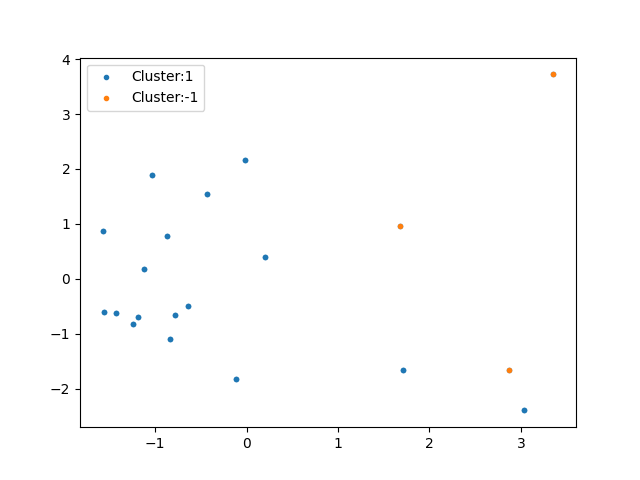

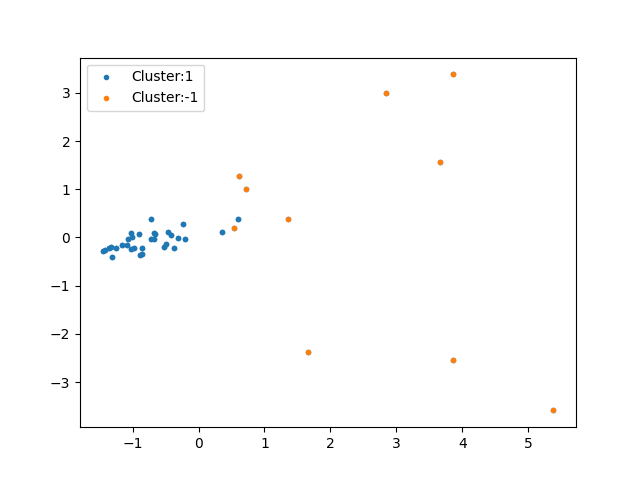

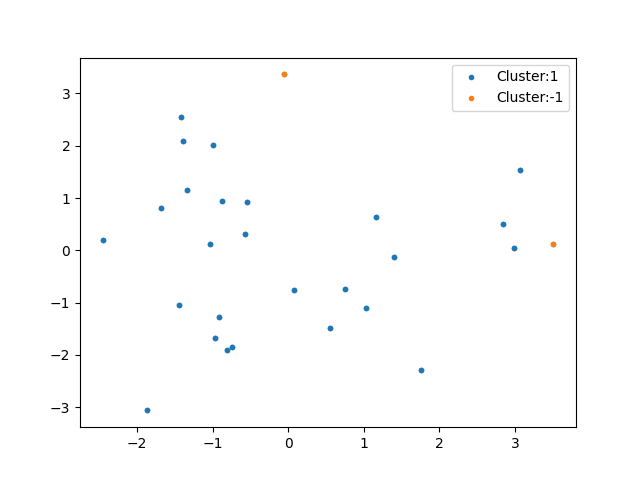

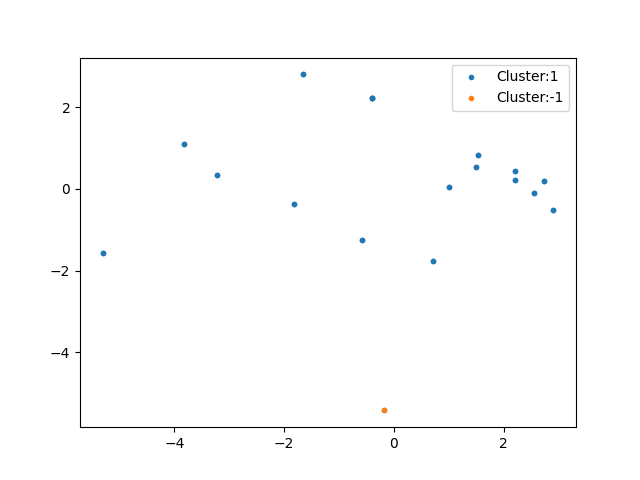

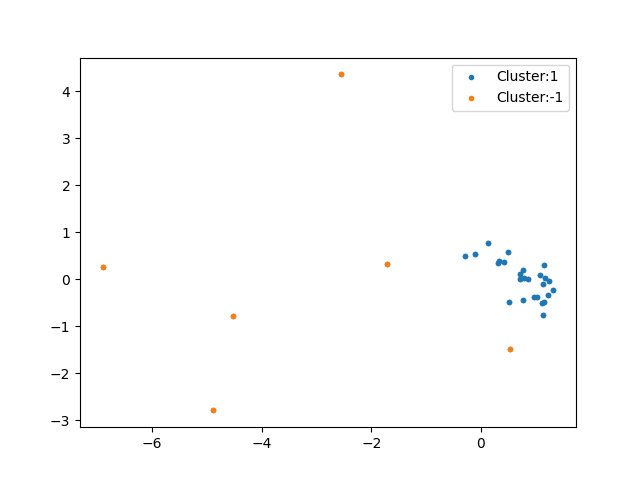

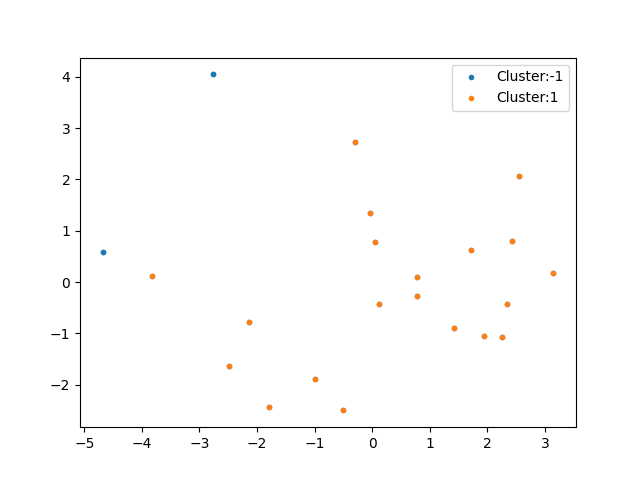

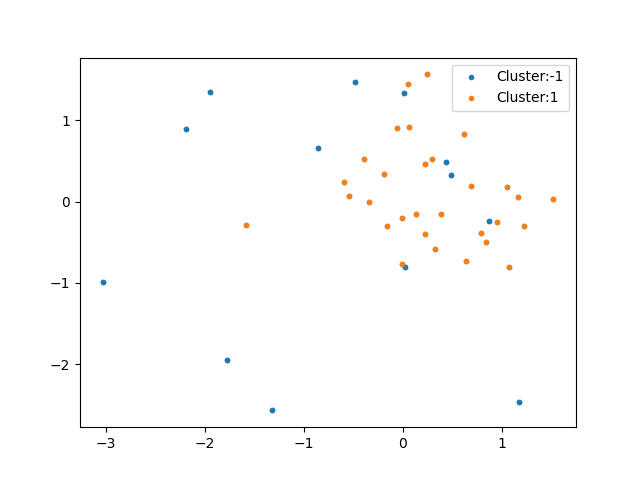

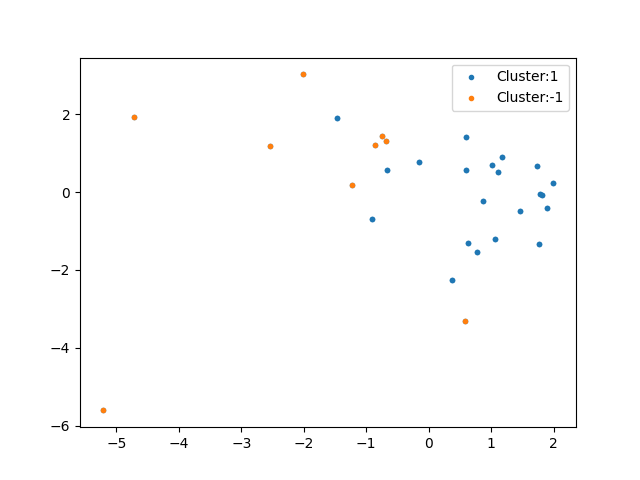

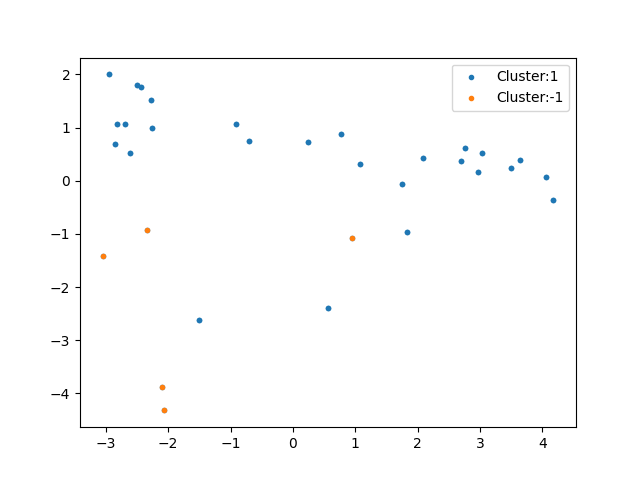

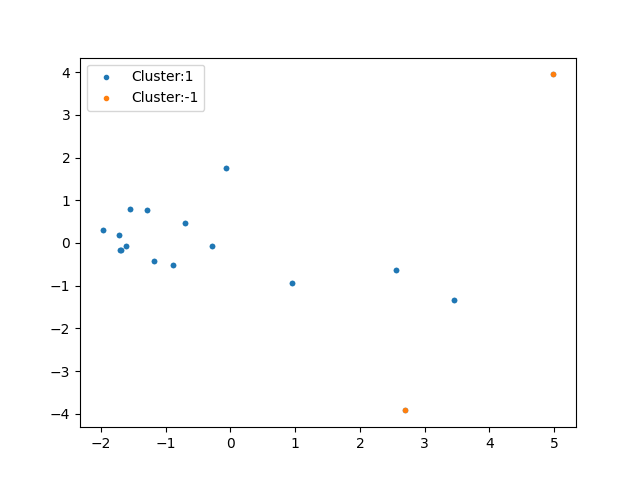

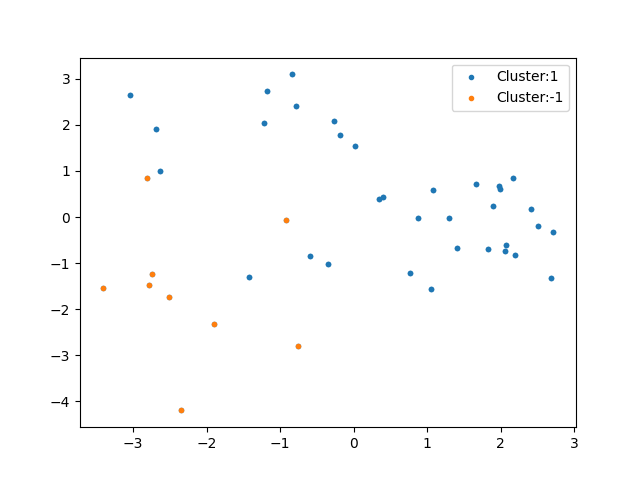

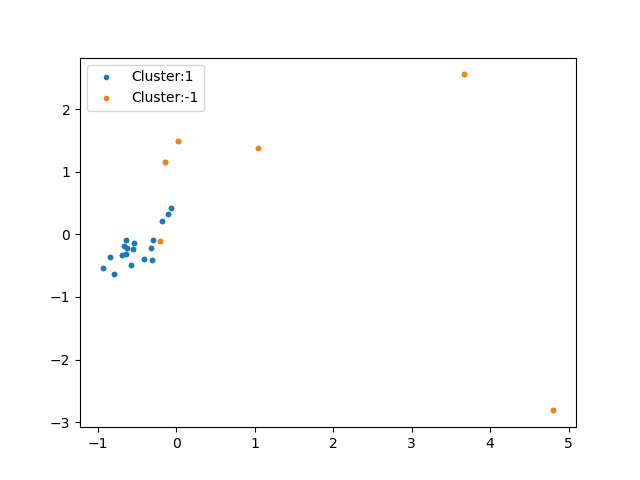

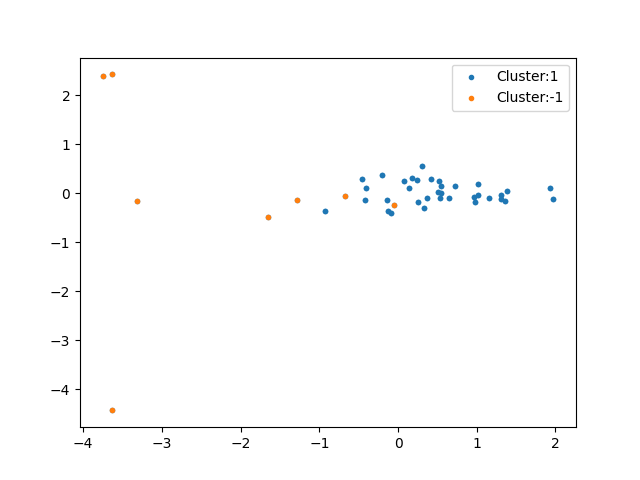

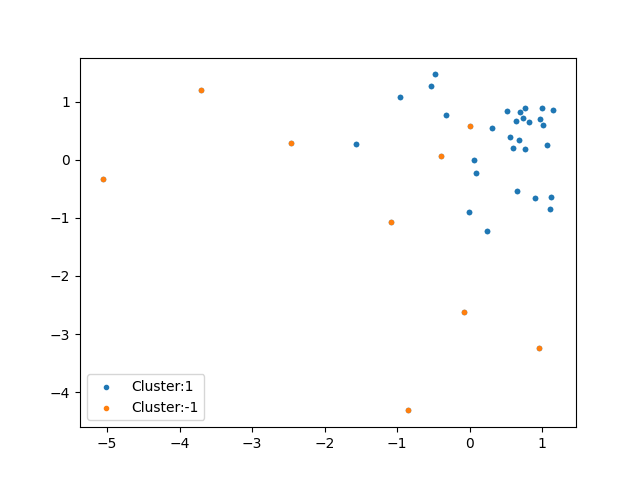

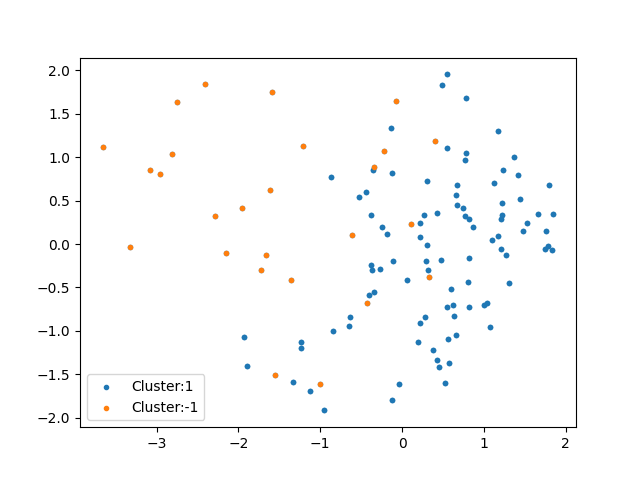

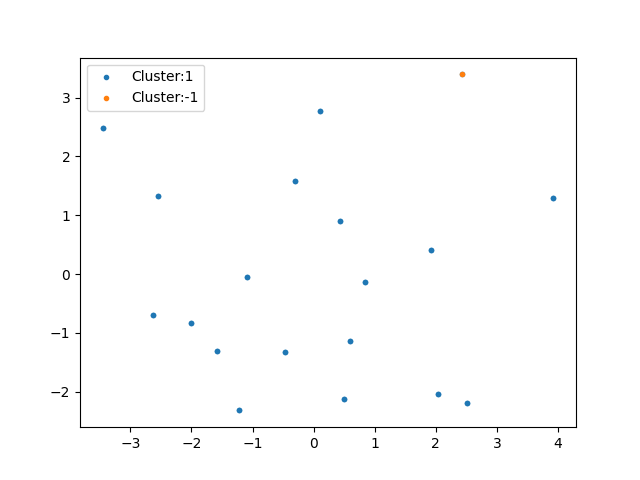

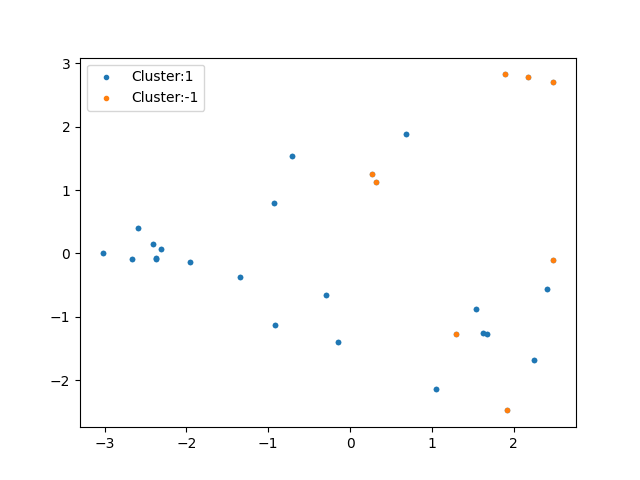

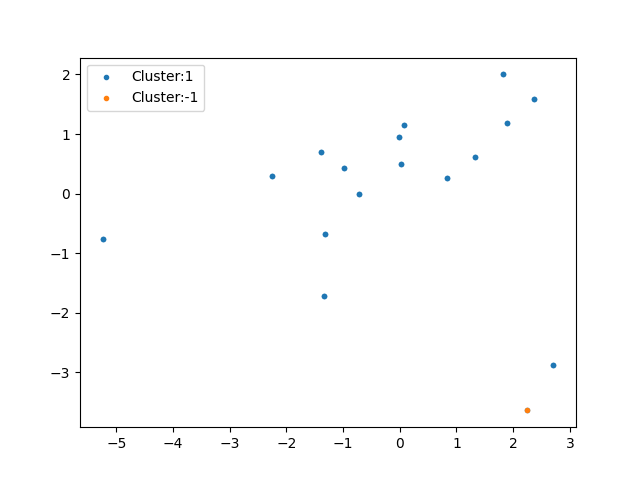

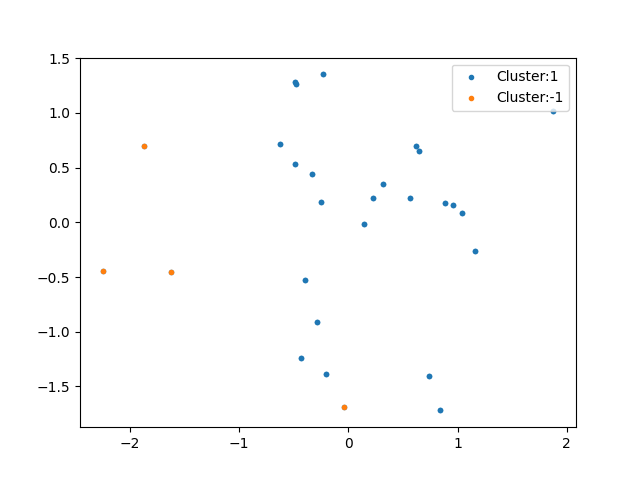

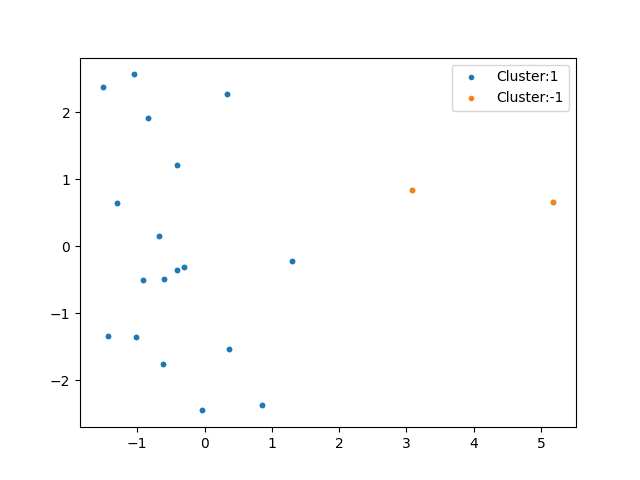

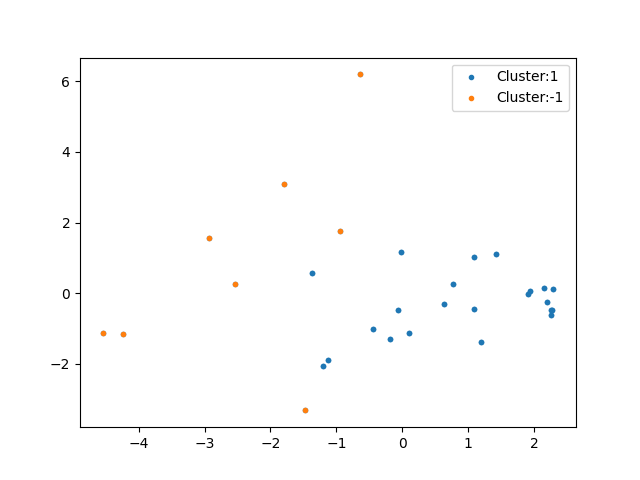

In [6]:
prev_end = 0
major_cluster_indexing = []
major_cluster_pts = []
chosen_cluster_parameters = defaultdict(lambda:0)
c=int(input("Enter C: "))
for label_num in range(101): 
    print(f"class: {label_num}",end="\r")   
    minPts = 10
    max_diff = 1e9
    overall_number_of_outliers = 1e9
    chosen_clusters = None
    cluster_count_dict = {}
    label_dist_mat = get_label_distance_matrix(d_matrix,label_image_ids[label_num])
    for k in range(minPts,1,-1):
        # getting the distances between each point and its K'th neighbor( where k is a minPts value)
        d = calculate_kn_distance_v2(label_dist_mat,k)
        # generating combinations using k as Minpts and epsilon values
        combi = create_combinations2(min(d),np.mean(d),k,100)
        # Iterating through all generated combinations,for each combination generated, applying dbscan on data.
        for i,j in combi:
            clusters = dbscan_v2(label_dist_mat,i,j)
            temp = cluster_count(clusters)
            current_no_of_outliers=1e10
            # counting number of valid clusters generated by dbscan for current combination of minpts and epsilon
            count = 0
            for i in temp:
                if i!=-1:
                    count+=1
            # getting number of points classified as noise by dbscan for current combination of minpts and epsilon   
            if( -1 in temp):
                current_no_of_outliers=temp[-1]
            else:
                current_no_of_outliers=0
            # for first occurance where number of clusters generated = required number of links 
            if count==c and max_diff!=0:
                max_diff = 0
                chosen_clusters = clusters
                chosen_cluster_parameters[label_num] = (i,j)
                # recording number of points as noise in current chosen cluster
                overall_number_of_outliers=current_no_of_outliers
            # for occurance of number of clusters generated = c and if noise in current cluster is lesser than previous chosen clusters
            if count==c and max_diff==0 and current_no_of_outliers<overall_number_of_outliers:
                chosen_clusters = clusters
                chosen_cluster_parameters[label_num] = (i,j)
                overall_number_of_outliers=current_no_of_outliers

            if (abs(c-count)==max_diff and current_no_of_outliers<overall_number_of_outliers) or (abs(c-count)<max_diff):
                chosen_clusters = clusters
                chosen_cluster_parameters[label_num] = (i,j)
                max_diff = abs(c-count)
                overall_number_of_outliers=current_no_of_outliers
    
    get_core_points(label_num,label_dist_mat,label_dataset[label_num],chosen_cluster_parameters[label_num][0],chosen_cluster_parameters[label_num][1])
    # finding cluster with maximum number of points and using the major cluster as a representative of the label
    major_cluster = None
    var1 = cluster_count(chosen_clusters)
    for i,j in var1.items():     
        if j==max(var1.values()):
            major_cluster = i
    # getting the points that belong to chosen_cluster using the indices of the list corresponding to their cluster ids
    chosen_cluster_points = []
    for index,cluster in enumerate(chosen_clusters):
        if cluster ==major_cluster:
            chosen_cluster_points.append(label_dataset[label_num][index])
    # creating an indexing for noting the points of the major clusters that represent each label
    major_cluster_indexing.append((prev_end,prev_end+len(chosen_cluster_points)-1))
    prev_end +=len(chosen_cluster_points) 
    # adding major cluster points of each label to one big list that contains all major cluster points of all label
    major_cluster_pts+=chosen_cluster_points
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xybox=(50., 50.)
    im = OffsetImage(dataset[0][0],zoom=.25)
    ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
            boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
    # add it to the axes and make it invisible
    ax.add_artist(ab)
    ab.set_visible(False)

    chosen_cluster_indices = defaultdict(list)
    original_images = []
    reduced_data=mds.mds(np.array(label_dataset[label_num]),2)
    for i,c in enumerate(chosen_clusters):
        chosen_cluster_indices[c].append((i,reduced_data[i]))
        original_images.append(dataset[label_image_ids[label_num][i]][0])
    
    overall_x,overall_y,overall_indices = [],[],[]  
    for i,clusters in chosen_cluster_indices.items():      
        x,y,indices = [],[],[]
        for j,pt in clusters:
            x.append(pt[0])
            overall_x.append(pt[0])
            y.append(pt[1])
            overall_y.append(pt[1])
            indices.append(j)
            overall_indices.append(j)
        plt.scatter(x,y,marker=".",label = f"Cluster:{i}", zorder=1)

    line, = ax.plot(overall_x,overall_y, ls="", marker=".", zorder=0)
    def hover(event, him=im,hab = ab,hline=line, hoverall_x = overall_x,hoverall_y = overall_y,horiginal_images = original_images,hoverall_indices = overall_indices,hfig = fig):
        if hline.contains(event)[0]:
            try:
                # find out the index within the array from the event
                ind, = hline.contains(event)[1]["ind"]
                w,h = hfig.get_size_inches()*hfig.dpi
                ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
                hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
                hab.xybox = (xybox[0]*ws, xybox[1]*hs)
                hab.set_visible(True)
                # place it at the position of the hovered scatter point
                hab.xy =(hoverall_x[ind], hoverall_y[ind])
                # set the image corresponding to that point
                him.set_data(horiginal_images[hoverall_indices[ind]])
            except:
                pass
        else:
            hab.set_visible(False)
        hfig.canvas.draw_idle()

    plt.legend()
    fig.canvas.mpl_connect('motion_notify_event', hover)        
    plt.show()

In [7]:
# Function to predict the labels of input images using the points that belongs to the major cluster of each label
def predict_label(pt,cluster_pts_lst,cluster_indexing):
    minPts = 51
    kn_distance = []
    for i in range(len(cluster_pts_lst)):
        kn_distance.append((i,euclidean_distance(cluster_pts_lst[i],pt)))
    kn_distance = sorted(kn_distance,key=lambda a:a[1])
    poll = defaultdict(lambda: 0)
    for i,_ in kn_distance[:minPts]:
        for label,ele in enumerate(cluster_indexing):
            if i>=ele[0] and i<=ele[1]:
                poll[label] +=1
                break
    predicted_label = sorted(poll.items(),key = lambda a:a[1], reverse=True)[0][0]
    return predicted_label

#prediction of odd images
predicted_labels = []
actual_labels = []
for dictionary in odd_dataset:
    predicted_labels.append(predict_label(dictionary[f"{featurespace}_feature_descriptor"],major_cluster_pts,major_cluster_indexing))
    actual_labels.append(dictionary['label'])

accuracy.calculate_labelwise_metrics(accuracy.get_OneHot(actual_labels), accuracy.get_OneHot(predicted_labels))

hello
i am here
+-------+-----------+--------+----------+
| Label | Precision | Recall | F1-Score |
+-------+-----------+--------+----------+
|   0   |    1.0    | 0.0321 |  0.0622  |
|   1   |   0.5082  | 0.9954 |  0.6729  |
|   2   |   0.8197  |  1.0   |  0.9009  |
|   3   |   0.911   |  1.0   |  0.9534  |
|   4   |    1.0    | 0.9286 |  0.963   |
|   5   |   0.8599  | 0.9975 |  0.9236  |
|   6   |     0     |  0.0   |    0     |
|   7   |    0.8    | 0.1905 |  0.3077  |
|   8   |    1.0    | 0.6087 |  0.7568  |
|   9   |   0.9545  | 0.7778 |  0.8571  |
|   10  |   0.7273  | 0.6957 |  0.7111  |
|   11  |    1.0    | 0.2941 |  0.4545  |
|   12  |   0.9828  | 0.8906 |  0.9344  |
|   13  |   0.9024  | 0.7551 |  0.8222  |
|   14  |    0.7    | 0.3333 |  0.4516  |
|   15  |   0.9268  | 0.8837 |  0.9048  |
|   16  |    1.0    | 0.6889 |  0.8158  |
|   17  |   0.7826  |  0.72  |   0.75   |
|   18  |   0.8333  | 0.4545 |  0.5882  |
|   19  |   0.9677  | 0.9836 |  0.9756  |
|   20  |    1.0  